In [1]:
#Ev Fiyat Tahmin Modeli

In [2]:
#İş Problemi

#Her bir eve ait özelliklerin ve ev fiyatlarının bulunduğu veriseti kullanılarak,
#farklı tipteki evlerin fiyatlarına ilişkin bir makine öğrenmesi projesi
#gerçekleştirilmek istenmektedir.

In [3]:
#Veri Seti Hikayesi

#Ames, Lowa’daki konut evlerinden oluşan bu veri seti içerisinde 79 açıklayıcı değişken bulunduruyor. Kaggle üzerinde bir 
#yarışması da bulunan projenin veri seti ve yarışma sayfasına aşağıdaki linkten ulaşabilirsiniz. Veri seti bir kaggle 
#yarışmasına ait olduğundan dolayı train ve test olmak üzere iki farklı csv dosyası vardır. Test veri setinde ev fiyatları 
#boş bırakılmış olup, bu değerleri sizin tahmin etmeniz beklenmektedir.

#Toplam Gözlem 1460

#Sayısal Değişken 38

#Kategorik Değişken 43

In [4]:
import warnings
import joblib
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from skompiler import skompile
import graphviz
import missingno as msno

warnings.simplefilter(action='ignore', category=Warning)

In [5]:
#Görev 1

In [6]:
#Adım 1: Train ve Test veri setlerini okutup birleştiriniz. Birleştirdiğiniz veri üzerinden ilerleyiniz.
train = pd.read_csv("data/house_train.csv")
test = pd.read_csv("data/house_test.csv")

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
train.shape

(1460, 81)

In [9]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [10]:
test.shape

(1459, 80)

In [11]:
df = pd.concat((train, test)).reset_index(drop=True)

In [12]:
def check_df(dataframe, head=5):
    print("############Shape############")
    print(dataframe.shape)
    print("############Types############")
    print(dataframe.dtypes)
    print("############Tail############")
    print(dataframe.tail(head))
    print("############Head############")
    print(dataframe.head(head))
    print("############NA############")
    print(dataframe.isnull().sum())
    print("############Quantiles############")
    print(dataframe.describe([0,0.05, 0.25, 0.50, 0.75, 0.95,0.99,1]).T)

check_df(df)

############Shape############
(2919, 81)
############Types############
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 81, dtype: object
############Tail############
        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
2914  2915         160       RM         21.0     1936   Pave   NaN      Reg   
2915  2916         160       RM         21.0     1894   Pave   NaN      Reg   
2916  2917          20       RL        160.0    20000   Pave   NaN      Reg   
2917  2918          85       RL         62.0    10441   Pave   NaN      Reg   
2918  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
2914         Lvl    AllPub  ...        0    Na

In [13]:
for i in df.columns:
    print(df[i].value_counts())
    print('***************************************\n')

1       1
1940    1
1942    1
1943    1
1944    1
       ..
976     1
977     1
978     1
979     1
2919    1
Name: Id, Length: 2919, dtype: int64
***************************************

20     1079
60      575
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64
***************************************

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64
***************************************

60.0     276
80.0     137
70.0     133
50.0     117
75.0     105
        ... 
152.0      1
138.0      1
182.0      1
168.0      1
133.0      1
Name: LotFrontage, Length: 128, dtype: int64
***************************************

9600     44
7200     43
6000     34
9000     29
10800    25
         ..
15498     1
9439      1
7406      1
3013      1
10441     1
Name: LotArea, Length: 1951, dtype: i

In [14]:
# I'll fly the id variable because it doesn't make any sense
df.drop('Id', axis = 1, inplace=True)

In [15]:
#Adım 2: Numerik ve kategorik değişkenleri yakalayınız.

def grab_col_names(dataframe, cat_th=13, car_th=20):
    cat_cols= [col for col in df.columns if str(df[col].dtypes) in ["category","object", "bool"]]
    num_but_cat=[col for col in df.columns if df[col].nunique()<10 and df[col].dtypes in ["int", "float"]]
    cat_but_car= [col for col in df.columns if
                   df[col].nunique()>20 and str(df[col].dtypes) in ["category", "object"]]
    cat_cols= cat_cols+num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols= [col for col in df.columns if df[col].dtypes in ["int", "float"]]
    num_cols= [col for col in num_cols if col not in cat_cols]

    print(f"Observations): {dataframe.shape[0]}")
    print(f"Veriables): {dataframe.shape[1]}")
    print(f"cat_cols): {len(cat_cols)}")
    print(f"num_cols): {len(num_cols)}")
    print(f"cat_but_car): {len(cat_but_car)}")
    print(f"num_but_cat): {len(num_but_cat)}")

    return cat_cols, num_cols,cat_but_car, num_but_cat

cat_cols, num_cols,cat_but_car,num_but_cat= grab_col_names(df)

Observations): 2919
Veriables): 80
cat_cols): 52
num_cols): 27
cat_but_car): 1
num_but_cat): 10


In [16]:
#Adım 3: Gerekli düzenlemeleri yapınız. (Tip hatası olan değişkenler gibi)
df[cat_cols].dtypes

MSZoning          object
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinType2      object
Heating           object
HeatingQC         object
CentralAir        object
Electrical        object
KitchenQual       object
Functional        object
FireplaceQu       object
GarageType        object
GarageFinish      object
GarageQual        object
GarageCond        object
PavedDrive        object
PoolQC            object
Fence             object
MiscFeature       object


In [17]:
df[num_cols].dtypes

MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
TotRmsAbvGrd       int64
GarageYrBlt      float64
GarageArea       float64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
SalePrice        float64
dtype: object

In [18]:
df[cat_but_car].dtypes

Neighborhood    object
dtype: object

count    2919.000000
mean       57.137718
std        42.517628
min        20.000000
5%         20.000000
10%        20.000000
20%        20.000000
30%        20.000000
40%        30.000000
50%        50.000000
60%        60.000000
70%        60.000000
80%        80.000000
90%       120.000000
95%       160.000000
99%       190.000000
max       190.000000
Name: MSSubClass, dtype: float64


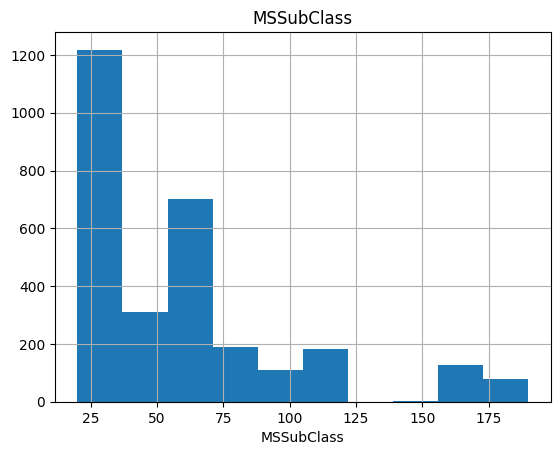

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
5%         32.000000
10%        43.000000
20%        53.000000
30%        60.000000
40%        63.000000
50%        68.000000
60%        73.000000
70%        78.000000
80%        84.000000
90%        95.000000
95%       107.000000
99%       135.680000
max       313.000000
Name: LotFrontage, dtype: float64


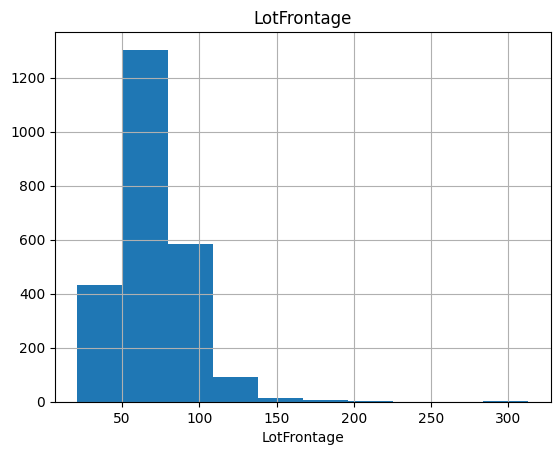

count      2919.000000
mean      10168.114080
std        7886.996359
min        1300.000000
5%         3182.000000
10%        4922.400000
20%        7007.600000
30%        7960.400000
40%        8741.000000
50%        9453.000000
60%       10151.600000
70%       11001.200000
80%       12203.800000
90%       14300.600000
95%       17142.900000
99%       33038.640000
max      215245.000000
Name: LotArea, dtype: float64


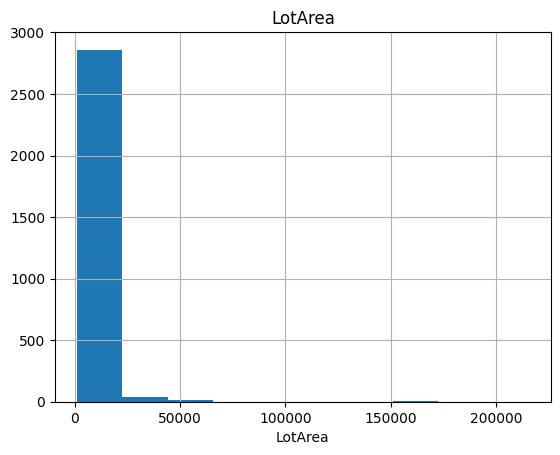

count    2919.000000
mean        6.089072
std         1.409947
min         1.000000
5%          4.000000
10%         5.000000
20%         5.000000
30%         5.000000
40%         6.000000
50%         6.000000
60%         6.000000
70%         7.000000
80%         7.000000
90%         8.000000
95%         8.000000
99%        10.000000
max        10.000000
Name: OverallQual, dtype: float64


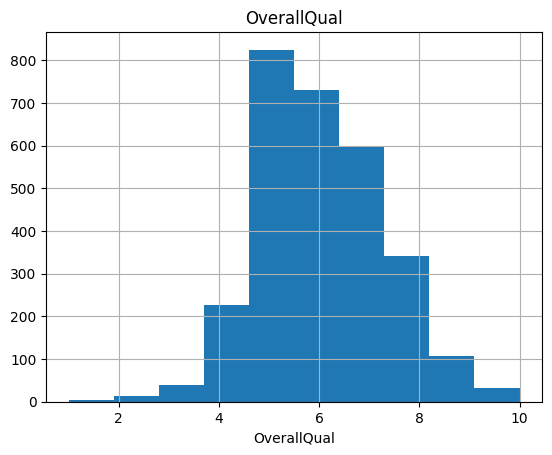

count    2919.000000
mean     1971.312778
std        30.291442
min      1872.000000
5%       1915.000000
10%      1924.000000
20%      1947.000000
30%      1957.000000
40%      1965.000000
50%      1973.000000
60%      1984.000000
70%      1998.000000
80%      2003.000000
90%      2006.000000
95%      2007.000000
99%      2008.000000
max      2010.000000
Name: YearBuilt, dtype: float64


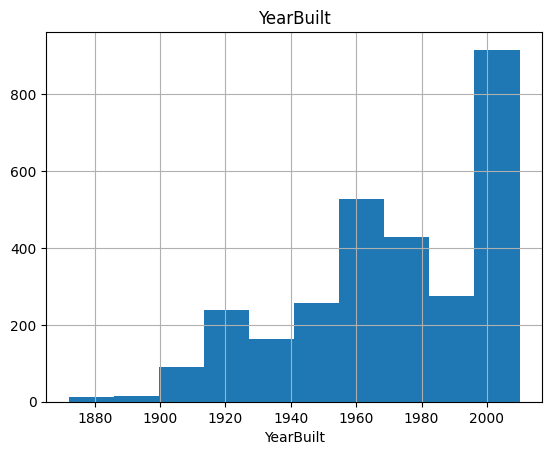

count    2919.000000
mean     1984.264474
std        20.894344
min      1950.000000
5%       1950.000000
10%      1950.000000
20%      1960.000000
30%      1970.000000
40%      1978.000000
50%      1993.000000
60%      1998.000000
70%      2002.000000
80%      2005.000000
90%      2006.200000
95%      2007.000000
99%      2009.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64


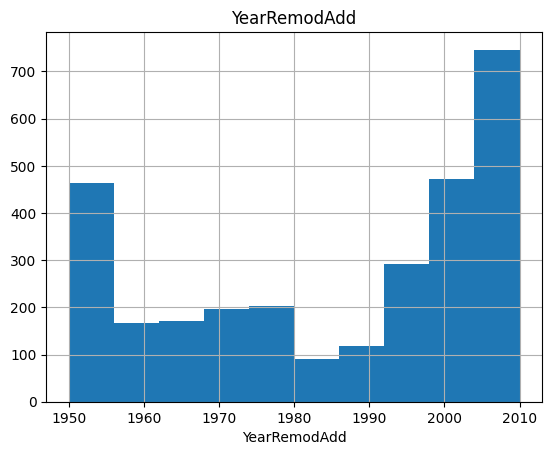

count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%       120.000000
80%       202.000000
90%       325.500000
95%       466.500000
99%       771.050000
max      1600.000000
Name: MasVnrArea, dtype: float64


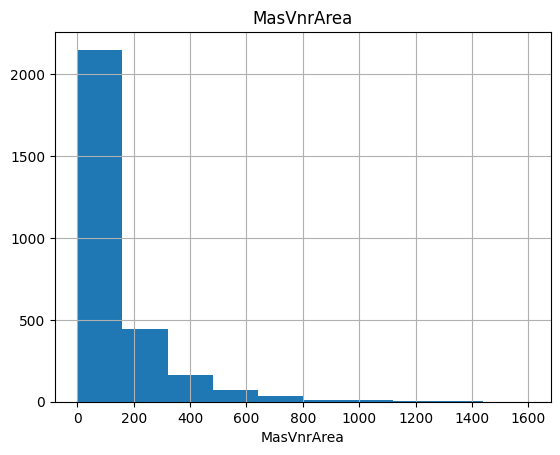

count    2918.000000
mean      441.423235
std       455.610826
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%       202.600000
50%       368.500000
60%       515.200000
70%       656.000000
80%       812.000000
90%      1056.900000
95%      1274.000000
99%      1635.320000
max      5644.000000
Name: BsmtFinSF1, dtype: float64


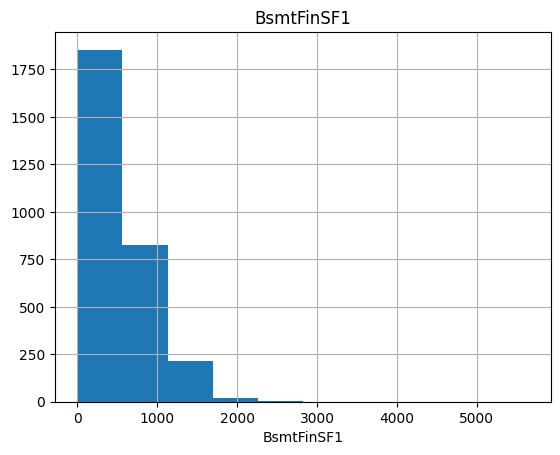

count    2918.000000
mean       49.582248
std       169.205611
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%       125.600000
95%       435.000000
99%       874.660000
max      1526.000000
Name: BsmtFinSF2, dtype: float64


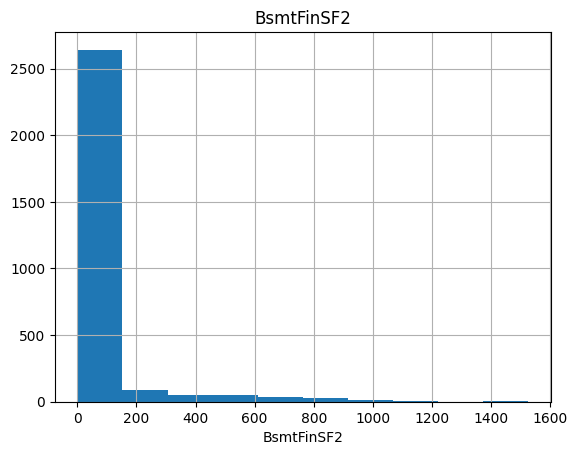

count    2918.000000
mean      560.772104
std       439.543659
min         0.000000
5%          0.000000
10%        56.000000
20%       174.000000
30%       270.000000
40%       365.800000
50%       467.000000
60%       595.000000
70%       732.000000
80%       892.600000
90%      1212.600000
95%      1474.900000
99%      1776.490000
max      2336.000000
Name: BsmtUnfSF, dtype: float64


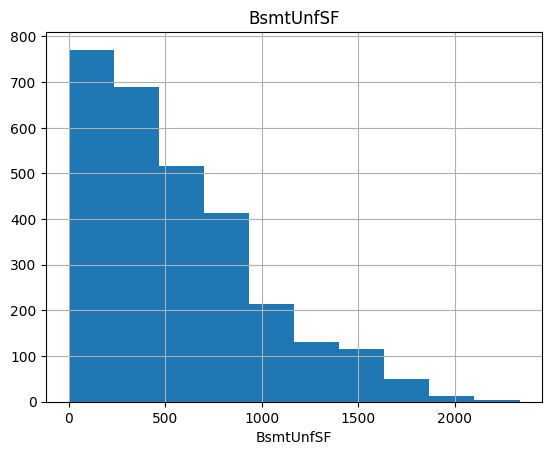

count    2918.000000
mean     1051.777587
std       440.766258
min         0.000000
5%        455.250000
10%       600.000000
20%       741.000000
30%       836.000000
40%       911.000000
50%       989.500000
60%      1089.200000
70%      1216.000000
80%      1392.000000
90%      1614.000000
95%      1776.150000
99%      2198.300000
max      6110.000000
Name: TotalBsmtSF, dtype: float64


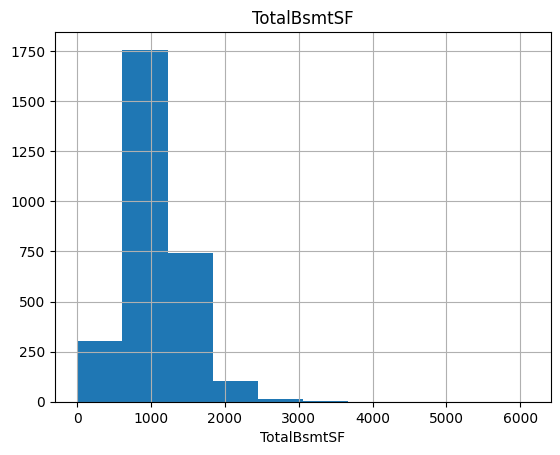

count    2919.000000
mean     1159.581706
std       392.362079
min       334.000000
5%        665.900000
10%       744.800000
20%       847.000000
30%       914.000000
40%       996.200000
50%      1082.000000
60%      1180.000000
70%      1314.000000
80%      1483.400000
90%      1675.000000
95%      1830.100000
99%      2288.020000
max      5095.000000
Name: 1stFlrSF, dtype: float64


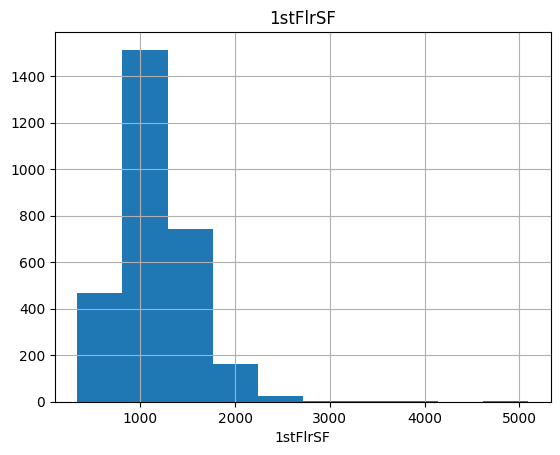

count    2919.000000
mean      336.483727
std       428.701456
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%       427.400000
70%       636.000000
80%       770.800000
90%       925.000000
95%      1131.200000
99%      1400.200000
max      2065.000000
Name: 2ndFlrSF, dtype: float64


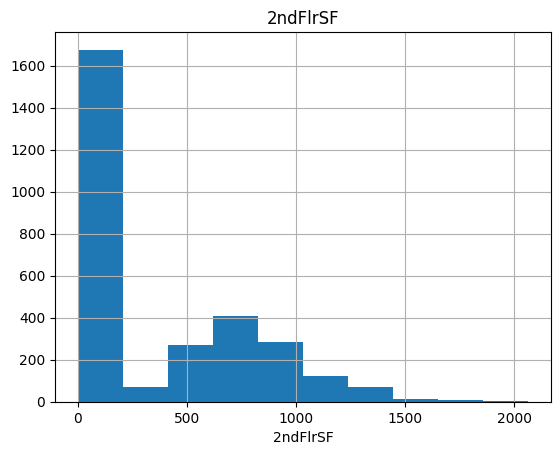

count    2919.000000
mean        4.694416
std        46.396825
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%       153.840000
max      1064.000000
Name: LowQualFinSF, dtype: float64


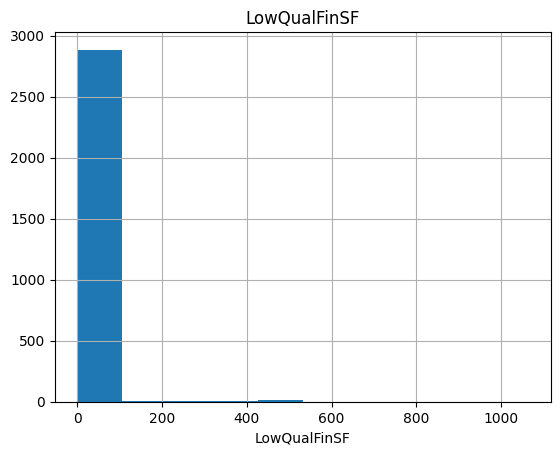

count    2919.000000
mean     1500.759849
std       506.051045
min       334.000000
5%        861.000000
10%       923.800000
20%      1064.600000
30%      1200.000000
40%      1329.200000
50%      1444.000000
60%      1560.000000
70%      1680.000000
80%      1838.400000
90%      2153.200000
95%      2464.200000
99%      2935.720000
max      5642.000000
Name: GrLivArea, dtype: float64


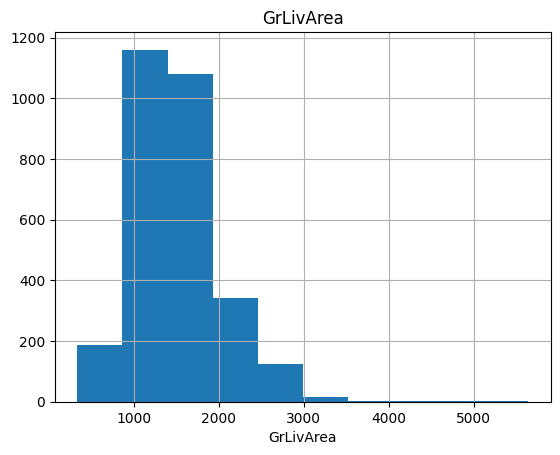

count    2919.000000
mean        6.451524
std         1.569379
min         2.000000
5%          4.000000
10%         5.000000
20%         5.000000
30%         6.000000
40%         6.000000
50%         6.000000
60%         7.000000
70%         7.000000
80%         8.000000
90%         8.000000
95%         9.000000
99%        11.000000
max        15.000000
Name: TotRmsAbvGrd, dtype: float64


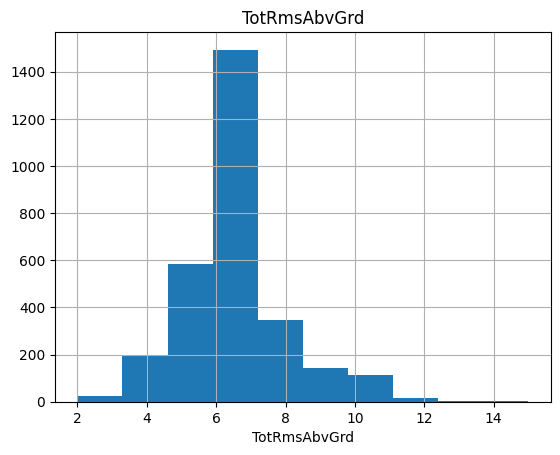

count    2760.000000
mean     1978.113406
std        25.574285
min      1895.000000
5%       1928.000000
10%      1941.000000
20%      1957.000000
30%      1964.000000
40%      1972.000000
50%      1979.000000
60%      1993.000000
70%      1999.000000
80%      2004.000000
90%      2006.000000
95%      2007.000000
99%      2009.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64


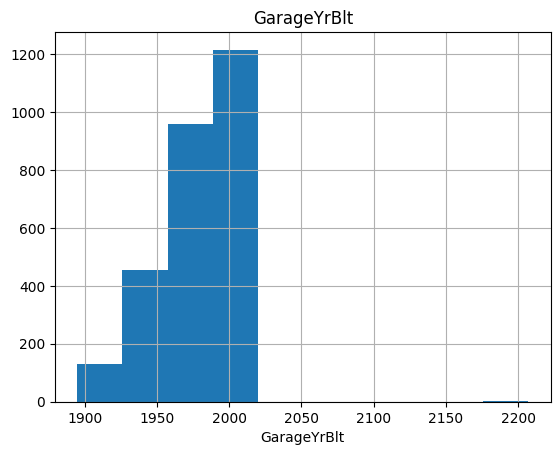

count    2918.000000
mean      472.874572
std       215.394815
min         0.000000
5%          0.000000
10%       240.000000
20%       296.000000
30%       379.000000
40%       440.000000
50%       480.000000
60%       513.000000
70%       560.900000
80%       621.000000
90%       758.000000
95%       856.150000
99%      1019.490000
max      1488.000000
Name: GarageArea, dtype: float64


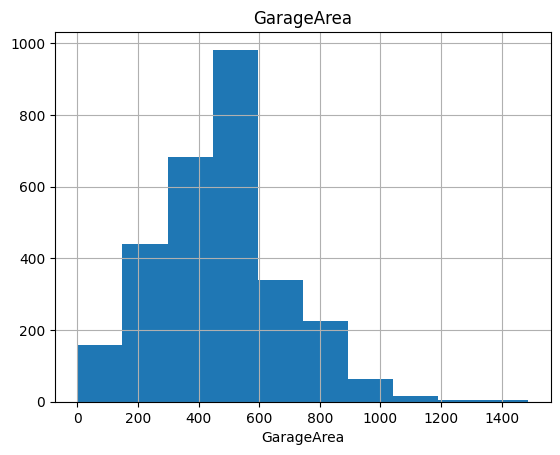

count    2919.000000
mean       93.709832
std       126.526589
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%       100.000000
70%       144.000000
80%       192.000000
90%       257.000000
95%       328.000000
99%       500.820000
max      1424.000000
Name: WoodDeckSF, dtype: float64


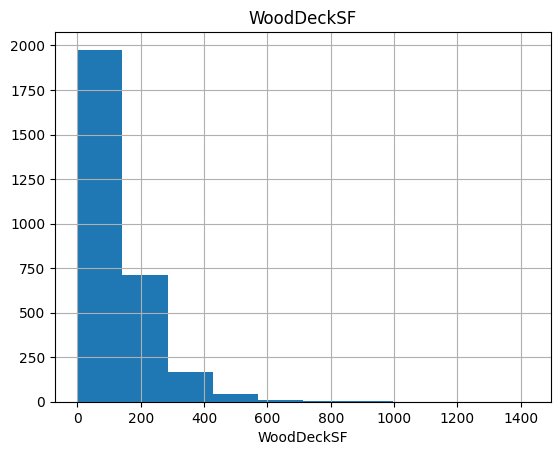

count    2919.000000
mean       47.486811
std        67.575493
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%        26.000000
60%        40.000000
70%        58.000000
80%        85.000000
90%       131.200000
95%       183.100000
99%       284.460000
max       742.000000
Name: OpenPorchSF, dtype: float64


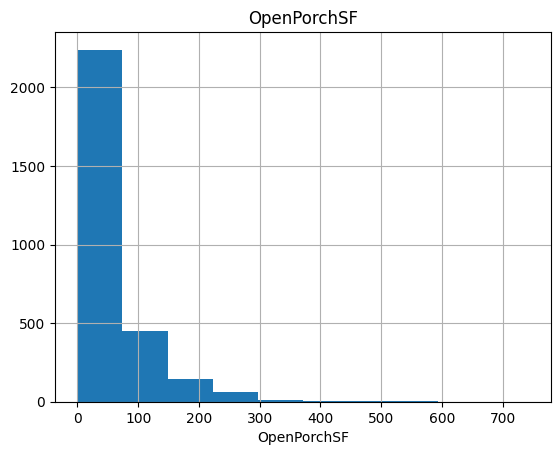

count    2919.000000
mean       23.098321
std        64.244246
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%       112.000000
95%       176.000000
99%       264.000000
max      1012.000000
Name: EnclosedPorch, dtype: float64


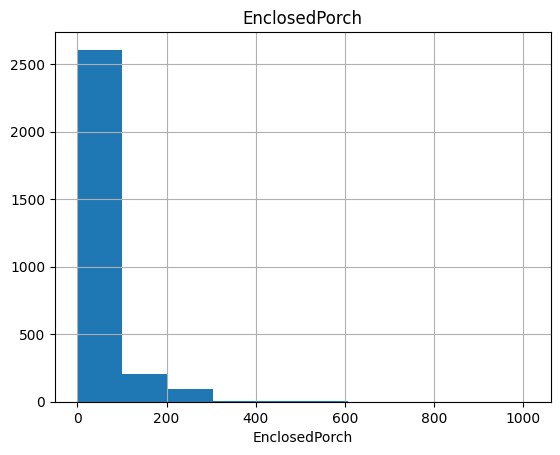

count    2919.000000
mean        2.602261
std        25.188169
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%       144.000000
max       508.000000
Name: 3SsnPorch, dtype: float64


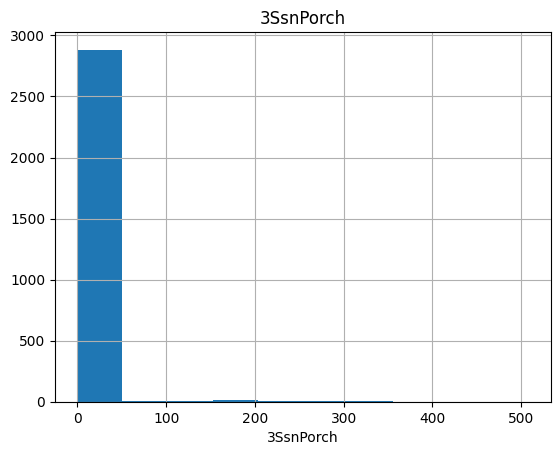

count    2919.000000
mean       16.062350
std        56.184365
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%       161.000000
99%       259.820000
max       576.000000
Name: ScreenPorch, dtype: float64


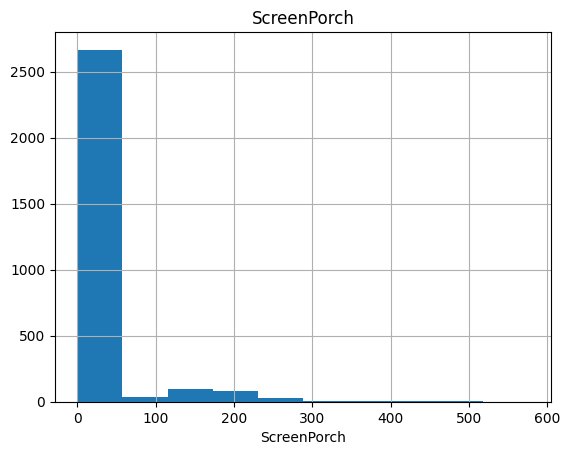

count    2919.000000
mean        2.251799
std        35.663946
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%         0.000000
max       800.000000
Name: PoolArea, dtype: float64


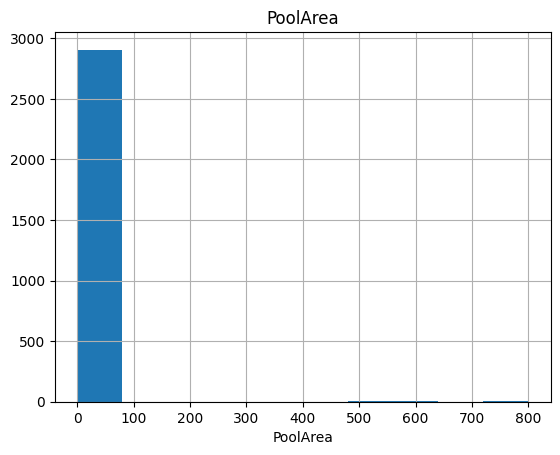

count     2919.000000
mean        50.825968
std        567.402211
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%          0.000000
80%          0.000000
90%          0.000000
95%          0.000000
99%        982.000000
max      17000.000000
Name: MiscVal, dtype: float64


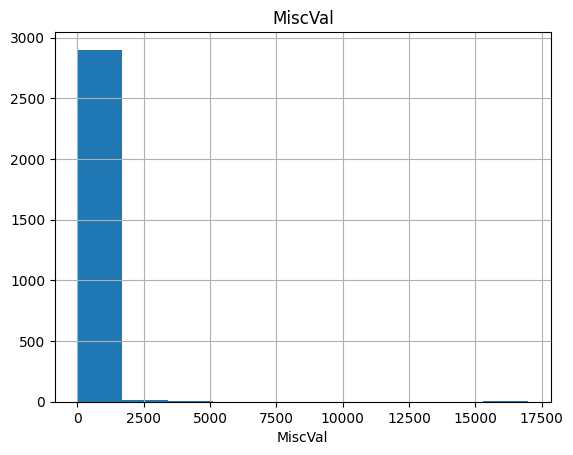

count    2919.000000
mean        6.213087
std         2.714762
min         1.000000
5%          2.000000
10%         3.000000
20%         4.000000
30%         5.000000
40%         6.000000
50%         6.000000
60%         7.000000
70%         7.000000
80%         8.000000
90%        10.000000
95%        11.000000
99%        12.000000
max        12.000000
Name: MoSold, dtype: float64


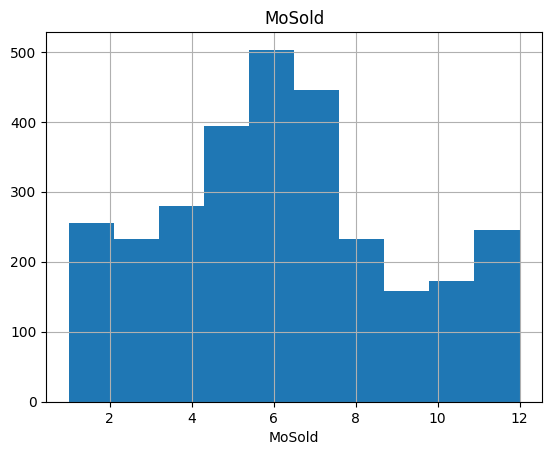

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
5%        88000.000000
10%      106475.000000
20%      124000.000000
30%      135500.000000
40%      147000.000000
50%      163000.000000
60%      179280.000000
70%      198620.000000
80%      230000.000000
90%      278000.000000
95%      326100.000000
99%      442567.010000
max      755000.000000
Name: SalePrice, dtype: float64


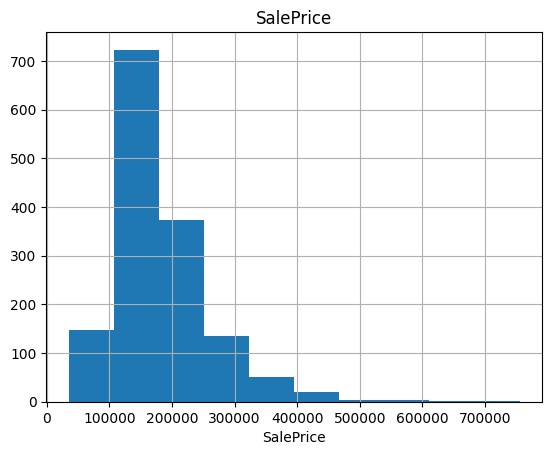

In [19]:
#Adım 4: Numerik ve kategorik değişkenlerin veri içindeki dağılımını gözlemleyiniz.

def num_summary(dataframe, numerical_col, plot= False):
    quantiles= [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    dataframe[numerical_col].describe().T
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block= True)

for col in num_cols:
    num_summary(df, col, plot=True)

         MSZoning      Ratio
RL           2265  77.595067
RM            460  15.758822
FV            139   4.761905
RH             26   0.890716
C (all)        25   0.856458
###########################################################


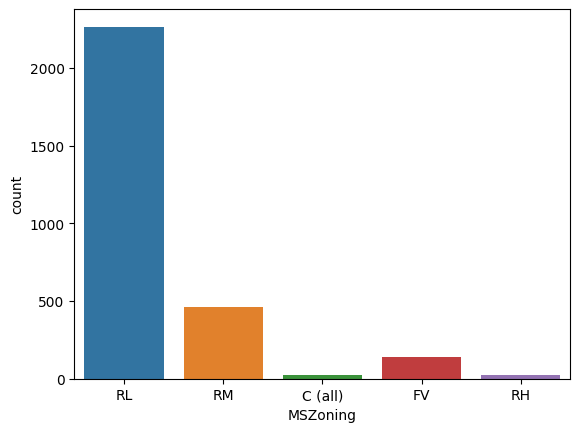

      Street    Ratio
Pave    2907  99.5889
Grvl      12   0.4111
###########################################################


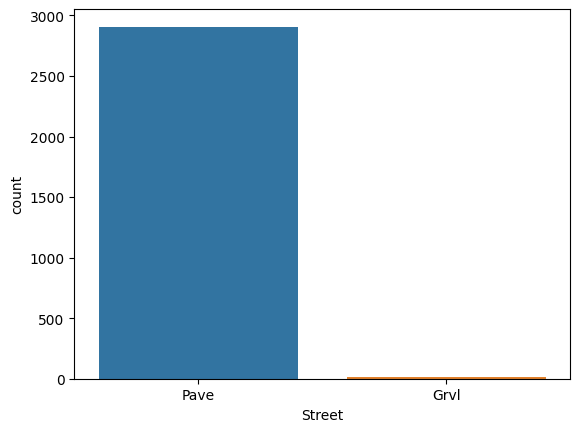

      Alley     Ratio
Grvl    120  4.110997
Pave     78  2.672148
###########################################################


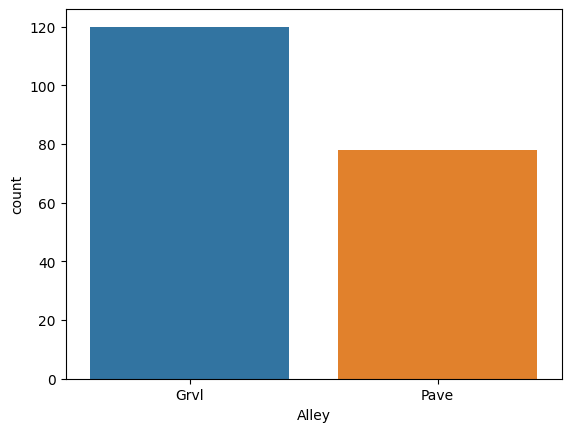

     LotShape      Ratio
Reg      1859  63.686194
IR1       968  33.162042
IR2        76   2.603631
IR3        16   0.548133
###########################################################


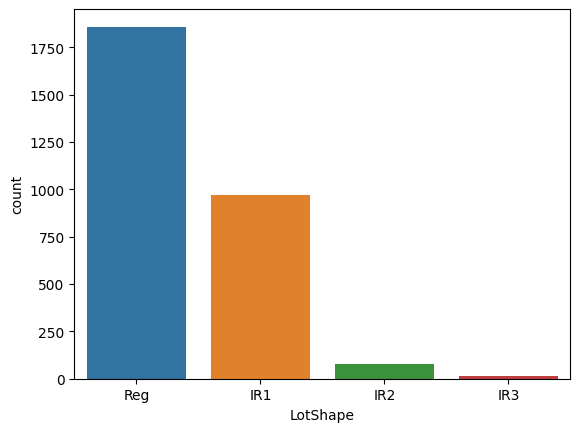

     LandContour      Ratio
Lvl         2622  89.825283
HLS          120   4.110997
Bnk          117   4.008222
Low           60   2.055498
###########################################################


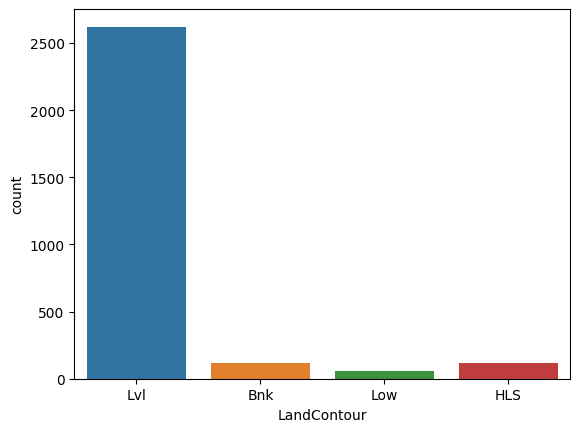

        Utilities      Ratio
AllPub       2916  99.897225
NoSeWa          1   0.034258
###########################################################


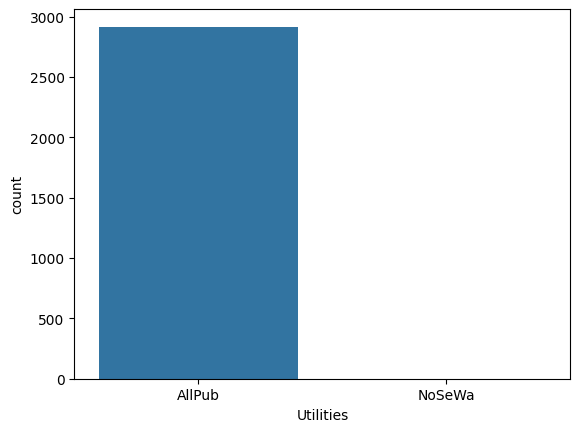

         LotConfig      Ratio
Inside        2133  73.072970
Corner         511  17.505995
CulDSac        176   6.029462
FR2             85   2.911956
FR3             14   0.479616
###########################################################


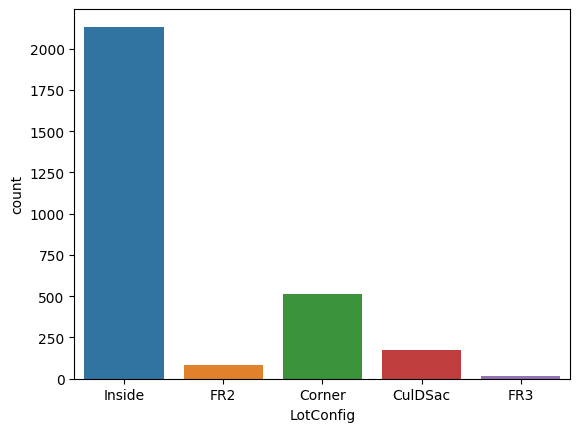

     LandSlope      Ratio
Gtl       2778  95.169579
Mod        125   4.282288
Sev         16   0.548133
###########################################################


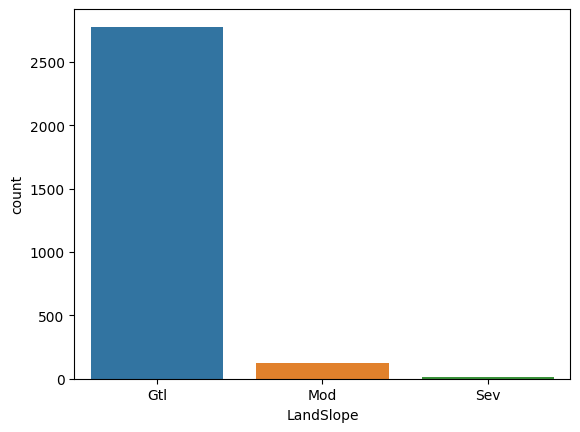

        Condition1      Ratio
Norm          2511  86.022610
Feedr          164   5.618362
Artery          92   3.151764
RRAn            50   1.712915
PosN            39   1.336074
RRAe            28   0.959233
PosA            20   0.685166
RRNn             9   0.308325
RRNe             6   0.205550
###########################################################


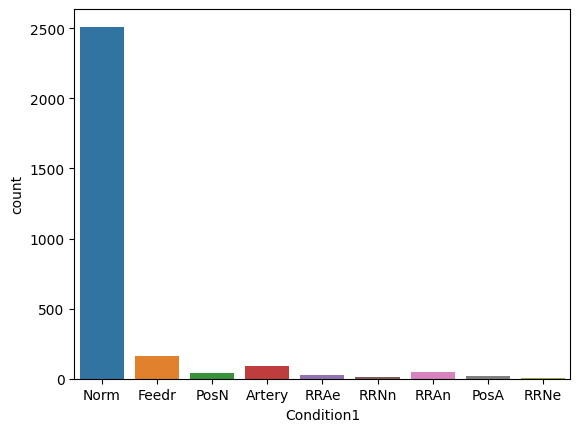

        Condition2      Ratio
Norm          2889  98.972251
Feedr           13   0.445358
Artery           5   0.171292
PosN             4   0.137033
PosA             4   0.137033
RRNn             2   0.068517
RRAn             1   0.034258
RRAe             1   0.034258
###########################################################


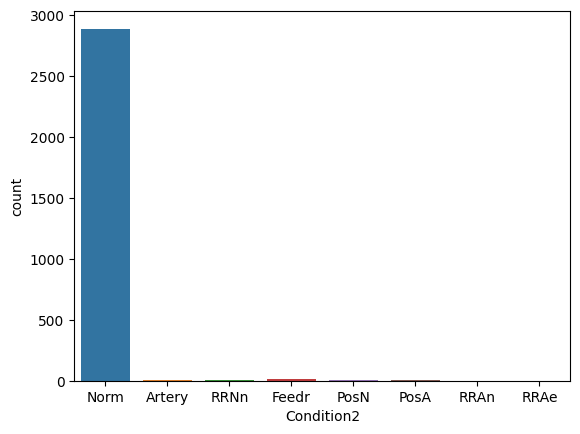

        BldgType      Ratio
1Fam        2425  83.076396
TwnhsE       227   7.776636
Duplex       109   3.734156
Twnhs         96   3.288798
2fmCon        62   2.124015
###########################################################


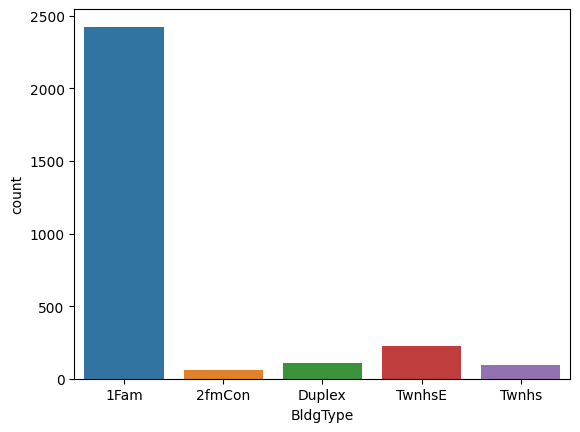

        HouseStyle      Ratio
1Story        1471  50.393971
2Story         872  29.873244
1.5Fin         314  10.757109
SLvl           128   4.385063
SFoyer          83   2.843440
2.5Unf          24   0.822199
1.5Unf          19   0.650908
2.5Fin           8   0.274066
###########################################################


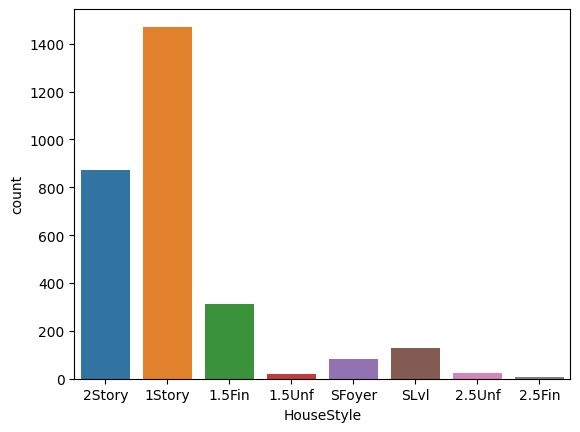

         RoofStyle      Ratio
Gable         2310  79.136691
Hip            551  18.876328
Gambrel         22   0.753683
Flat            20   0.685166
Mansard         11   0.376841
Shed             5   0.171292
###########################################################


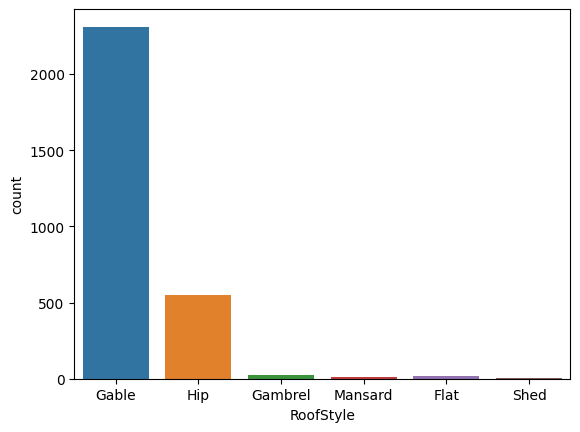

         RoofMatl      Ratio
CompShg      2876  98.526893
Tar&Grv        23   0.787941
WdShake         9   0.308325
WdShngl         7   0.239808
Metal           1   0.034258
Membran         1   0.034258
Roll            1   0.034258
ClyTile         1   0.034258
###########################################################


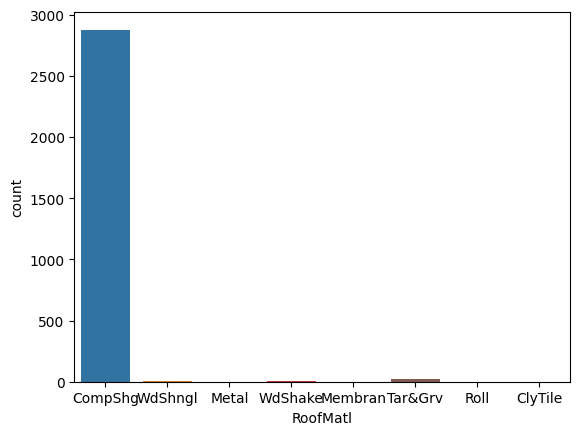

         Exterior1st      Ratio
VinylSd         1025  35.114765
MetalSd          450  15.416238
HdBoard          442  15.142172
Wd Sdng          411  14.080164
Plywood          221   7.571086
CemntBd          126   4.316547
BrkFace           87   2.980473
WdShing           56   1.918465
AsbShng           44   1.507366
Stucco            43   1.473107
BrkComm            6   0.205550
AsphShn            2   0.068517
Stone              2   0.068517
CBlock             2   0.068517
ImStucc            1   0.034258
###########################################################


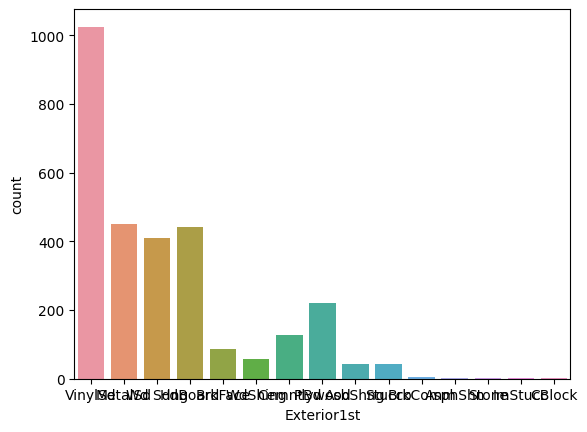

         Exterior2nd      Ratio
VinylSd         1014  34.737924
MetalSd          447  15.313464
HdBoard          406  13.908873
Wd Sdng          391  13.394998
Plywood          270   9.249743
CmentBd          126   4.316547
Wd Shng           81   2.774923
BrkFace           47   1.610140
Stucco            47   1.610140
AsbShng           38   1.301816
Brk Cmn           22   0.753683
ImStucc           15   0.513875
Stone              6   0.205550
AsphShn            4   0.137033
CBlock             3   0.102775
Other              1   0.034258
###########################################################


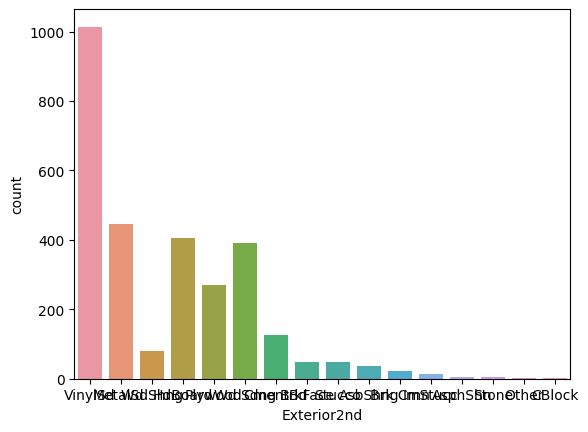

         MasVnrType      Ratio
None           1742  59.677972
BrkFace         879  30.113052
Stone           249   8.530319
BrkCmn           25   0.856458
###########################################################


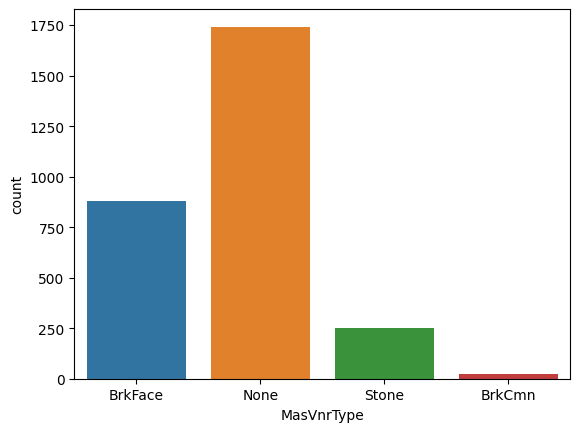

    ExterQual      Ratio
TA       1798  61.596437
Gd        979  33.538883
Ex        107   3.665639
Fa         35   1.199041
###########################################################


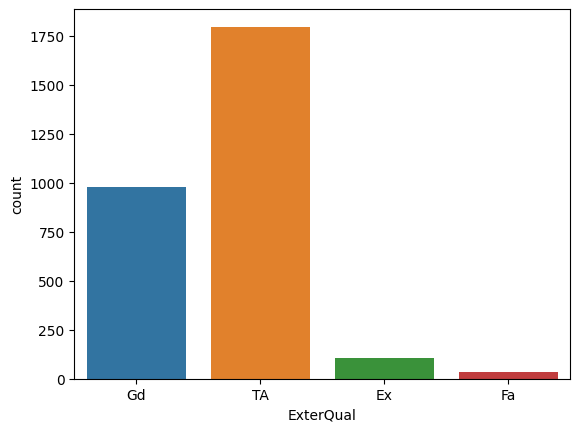

    ExterCond      Ratio
TA       2538  86.947585
Gd        299  10.243234
Fa         67   2.295307
Ex         12   0.411100
Po          3   0.102775
###########################################################


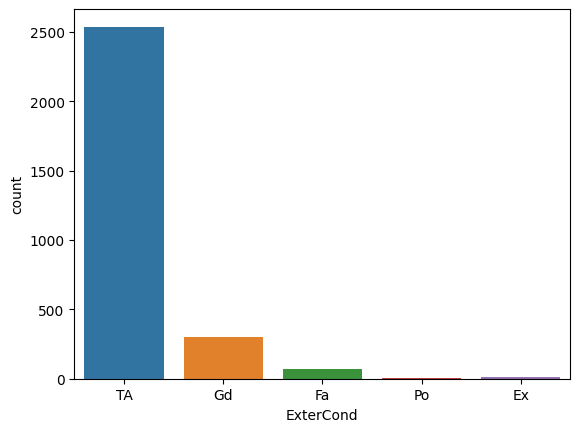

        Foundation      Ratio
PConc         1308  44.809866
CBlock        1235  42.309010
BrkTil         311  10.654334
Slab            49   1.678657
Stone           11   0.376841
Wood             5   0.171292
###########################################################


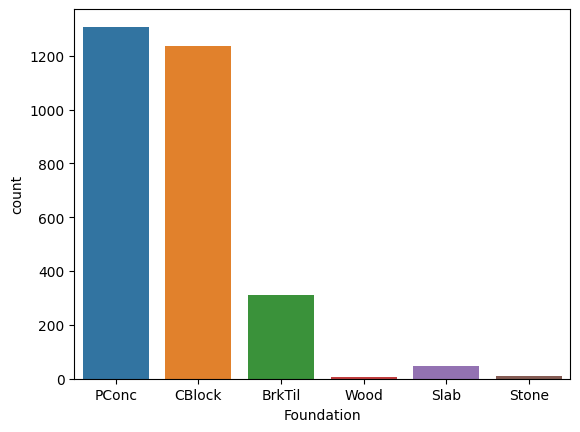

    BsmtQual      Ratio
TA      1283  43.953409
Gd      1209  41.418294
Ex       258   8.838643
Fa        88   3.014731
###########################################################


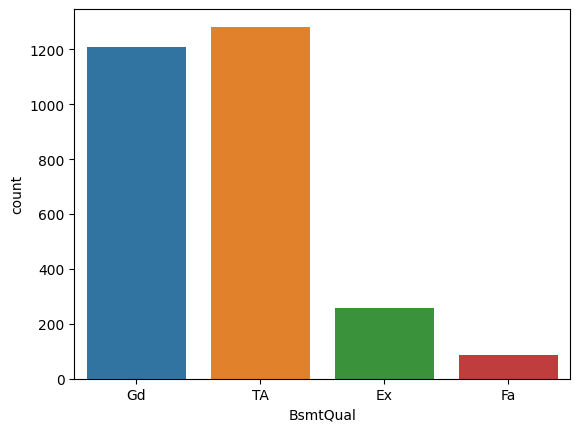

    BsmtCond      Ratio
TA      2606  89.277150
Gd       122   4.179514
Fa       104   3.562864
Po         5   0.171292
###########################################################


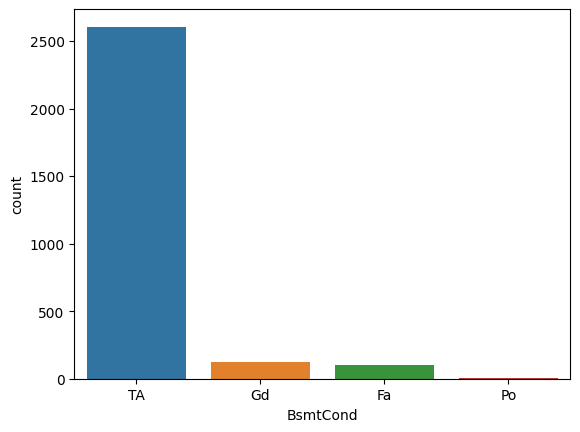

    BsmtExposure      Ratio
No          1904  65.227818
Av           418  14.319973
Gd           276   9.455293
Mn           239   8.187736
###########################################################


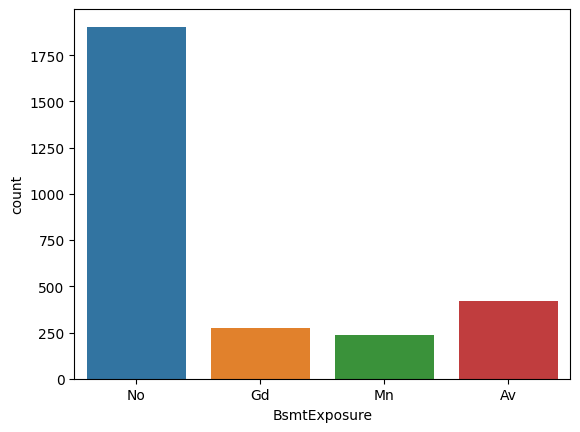

     BsmtFinType1      Ratio
Unf           851  29.153820
GLQ           849  29.085303
ALQ           429  14.696814
Rec           288   9.866393
BLQ           269   9.215485
LwQ           154   5.275779
###########################################################


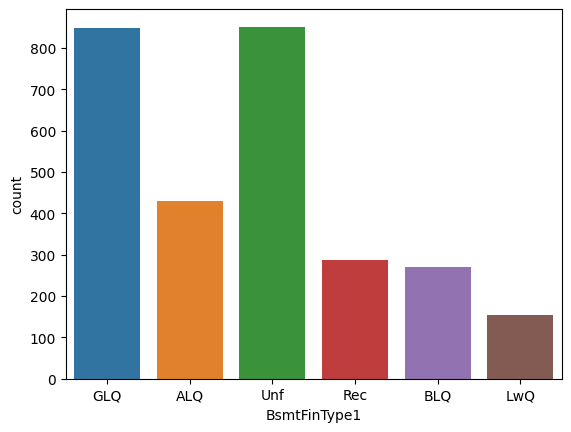

     BsmtFinType2      Ratio
Unf          2493  85.405961
Rec           105   3.597122
LwQ            87   2.980473
BLQ            68   2.329565
ALQ            52   1.781432
GLQ            34   1.164782
###########################################################


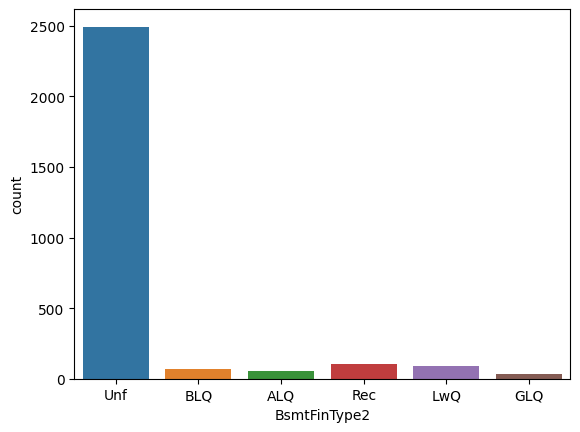

       Heating      Ratio
GasA      2874  98.458376
GasW        27   0.924974
Grav         9   0.308325
Wall         6   0.205550
OthW         2   0.068517
Floor        1   0.034258
###########################################################


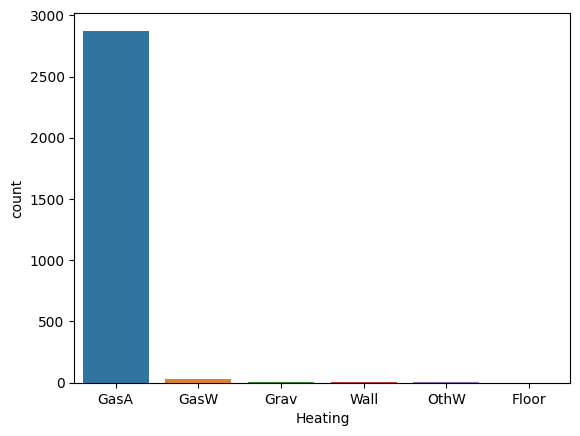

    HeatingQC      Ratio
Ex       1493  51.147653
TA        857  29.359370
Gd        474  16.238438
Fa         92   3.151764
Po          3   0.102775
###########################################################


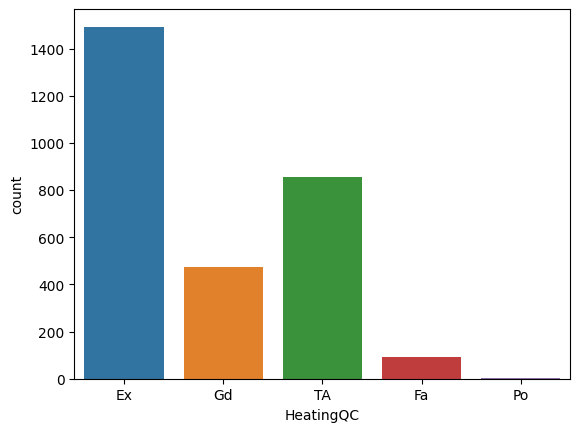

   CentralAir      Ratio
Y        2723  93.285372
N         196   6.714628
###########################################################


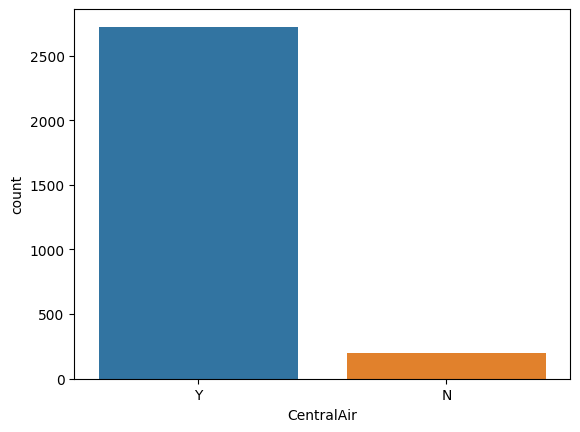

       Electrical      Ratio
SBrkr        2671  91.503940
FuseA         188   6.440562
FuseF          50   1.712915
FuseP           8   0.274066
Mix             1   0.034258
###########################################################


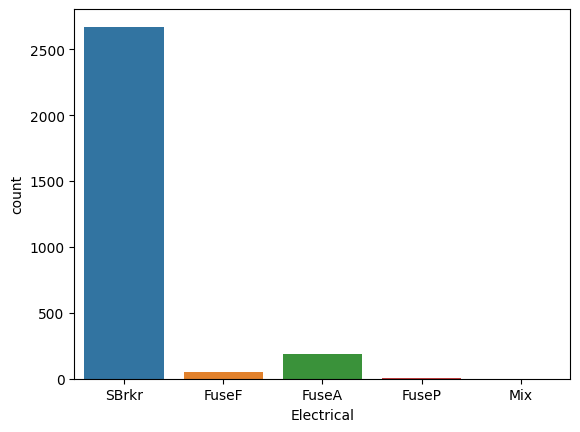

    KitchenQual      Ratio
TA         1492  51.113395
Gd         1151  39.431312
Ex          205   7.022953
Fa           70   2.398082
###########################################################


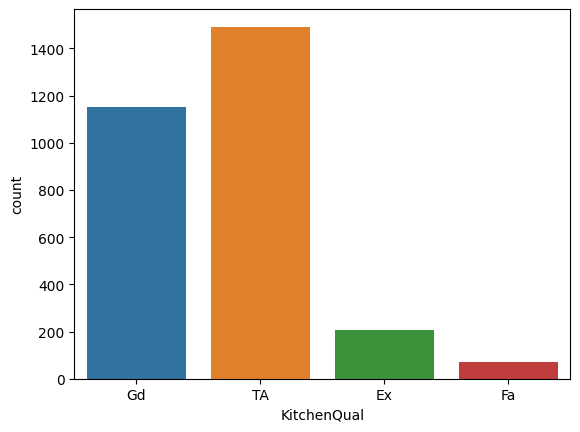

      Functional      Ratio
Typ         2717  93.079822
Min2          70   2.398082
Min1          65   2.226790
Mod           35   1.199041
Maj1          19   0.650908
Maj2           9   0.308325
Sev            2   0.068517
###########################################################


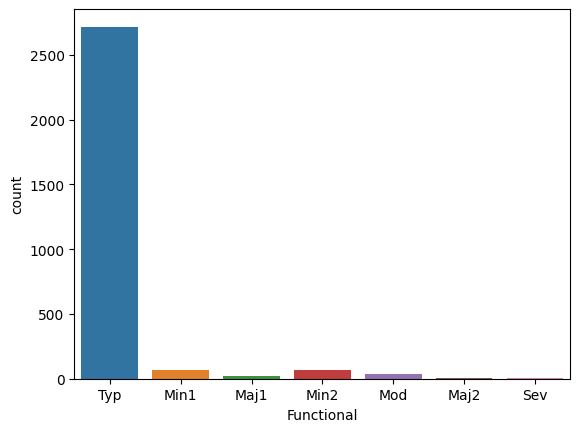

    FireplaceQu      Ratio
Gd          744  25.488181
TA          592  20.280918
Fa           74   2.535115
Po           46   1.575882
Ex           43   1.473107
###########################################################


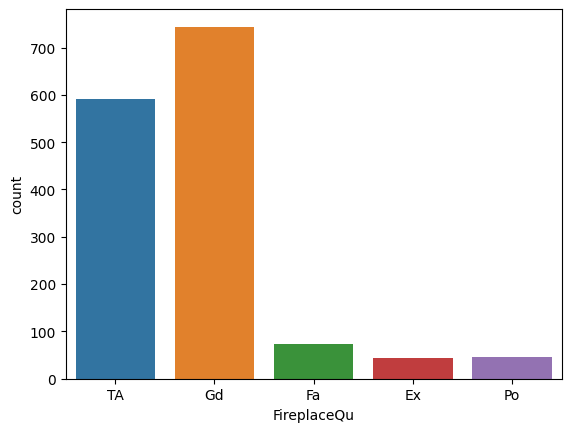

         GarageType      Ratio
Attchd         1723  59.027064
Detchd          779  26.687222
BuiltIn         186   6.372045
Basment          36   1.233299
2Types           23   0.787941
CarPort          15   0.513875
###########################################################


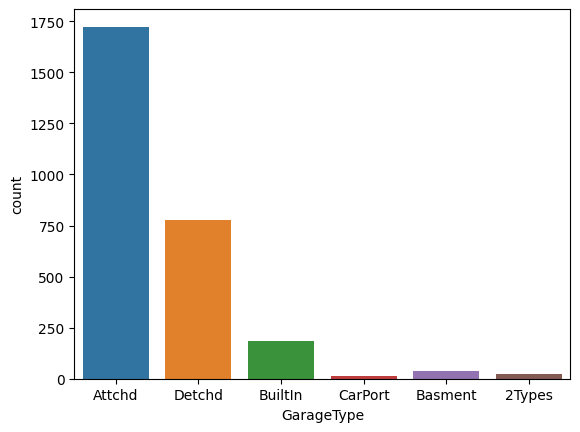

     GarageFinish      Ratio
Unf          1230  42.137718
RFn           811  27.783487
Fin           719  24.631723
###########################################################


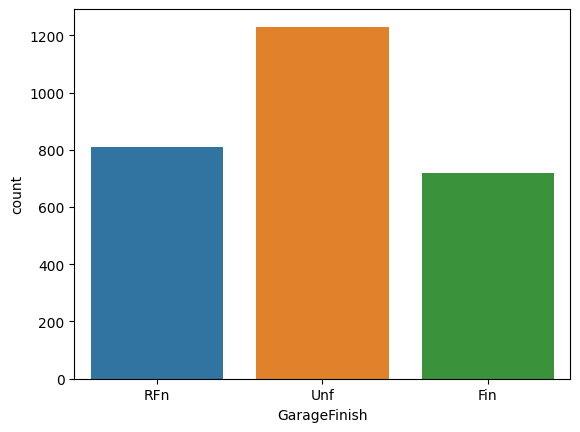

    GarageQual      Ratio
TA        2604  89.208633
Fa         124   4.248030
Gd          24   0.822199
Po           5   0.171292
Ex           3   0.102775
###########################################################


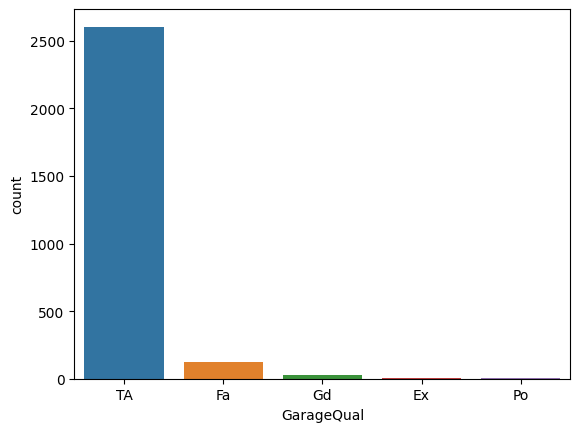

    GarageCond      Ratio
TA        2654  90.921548
Fa          74   2.535115
Gd          15   0.513875
Po          14   0.479616
Ex           3   0.102775
###########################################################


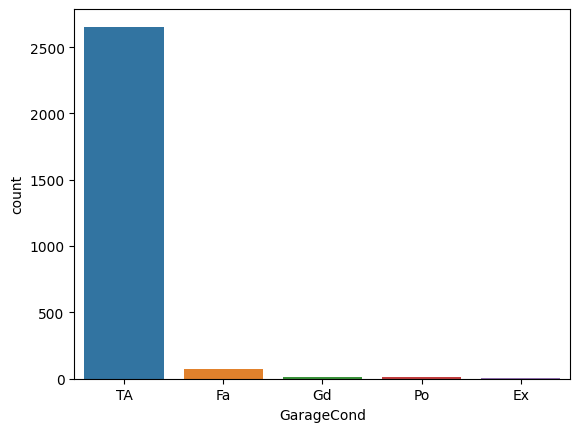

   PavedDrive      Ratio
Y        2641  90.476190
N         216   7.399794
P          62   2.124015
###########################################################


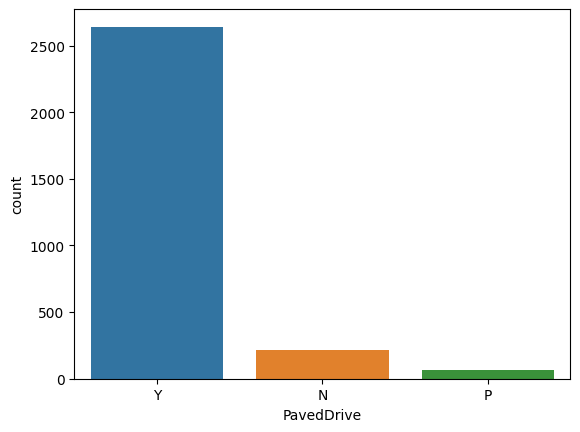

    PoolQC     Ratio
Ex       4  0.137033
Gd       4  0.137033
Fa       2  0.068517
###########################################################


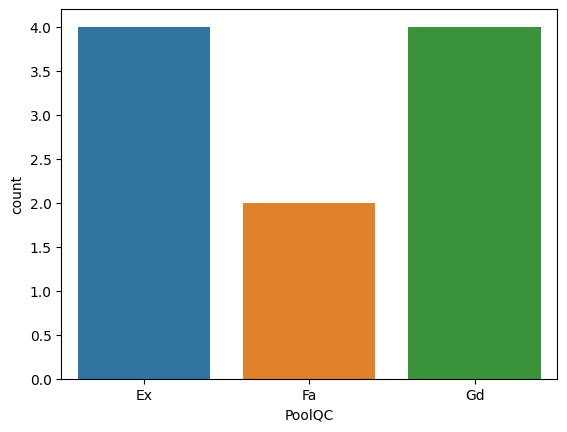

       Fence      Ratio
MnPrv    329  11.270983
GdPrv    118   4.042480
GdWo     112   3.836930
MnWw      12   0.411100
###########################################################


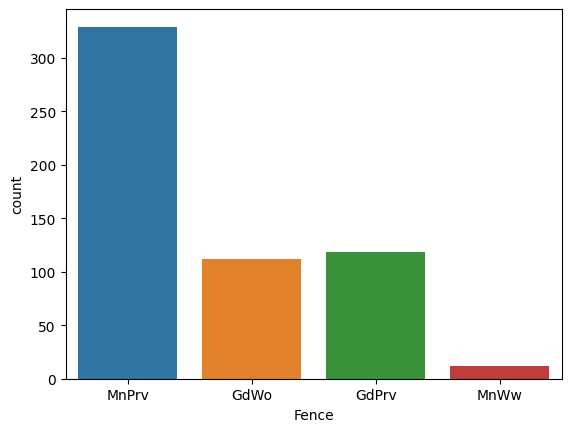

      MiscFeature     Ratio
Shed           95  3.254539
Gar2            5  0.171292
Othr            4  0.137033
TenC            1  0.034258
###########################################################


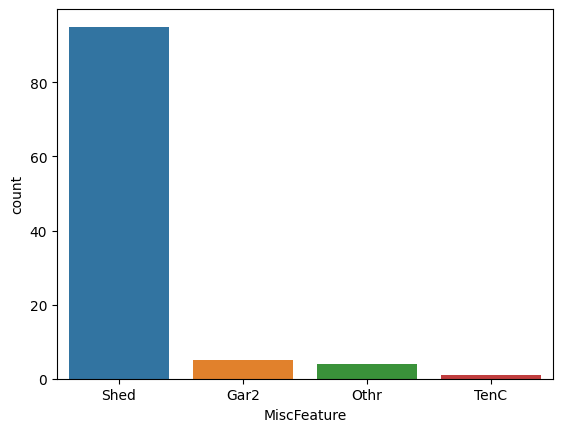

       SaleType      Ratio
WD         2525  86.502227
New         239   8.187736
COD          87   2.980473
ConLD        26   0.890716
CWD          12   0.411100
ConLI         9   0.308325
ConLw         8   0.274066
Oth           7   0.239808
Con           5   0.171292
###########################################################


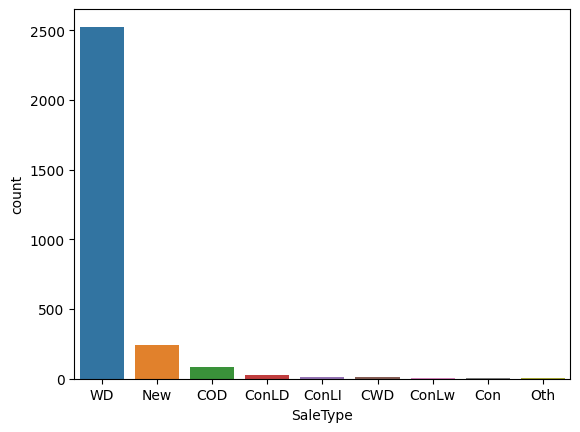

         SaleCondition      Ratio
Normal            2402  82.288455
Partial            245   8.393285
Abnorml            190   6.509078
Family              46   1.575882
Alloca              24   0.822199
AdjLand             12   0.411100
###########################################################


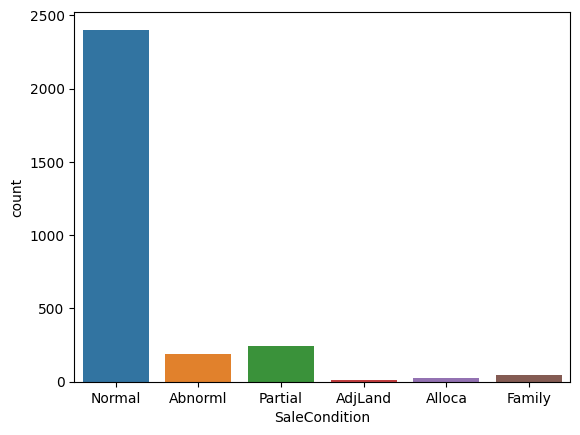

   OverallCond      Ratio
5         1645  56.354916
6          531  18.191161
7          390  13.360740
8          144   4.933196
4          101   3.460089
3           50   1.712915
9           41   1.404591
2           10   0.342583
1            7   0.239808
###########################################################


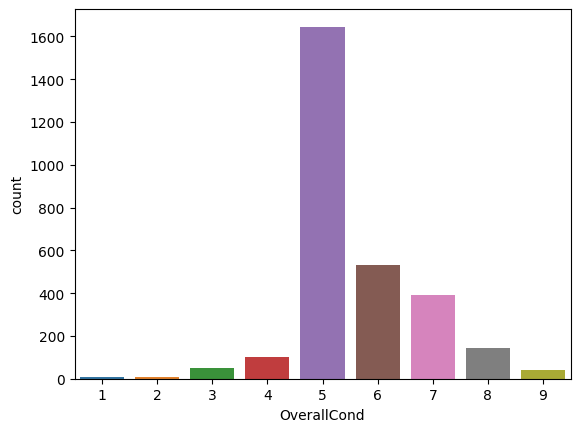

     BsmtFullBath      Ratio
0.0          1705  58.410415
1.0          1172  40.150737
2.0            38   1.301816
3.0             2   0.068517
###########################################################


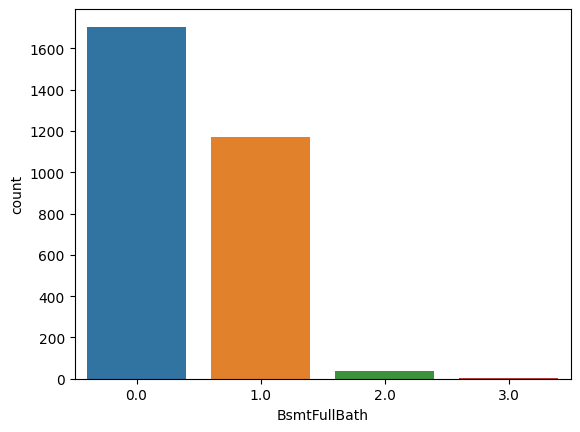

     BsmtHalfBath      Ratio
0.0          2742  93.936280
1.0           171   5.858171
2.0             4   0.137033
###########################################################


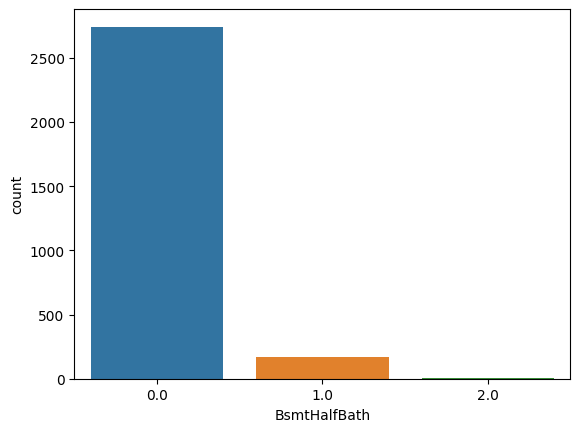

   FullBath      Ratio
2      1530  52.415211
1      1309  44.844125
3        64   2.192532
0        12   0.411100
4         4   0.137033
###########################################################


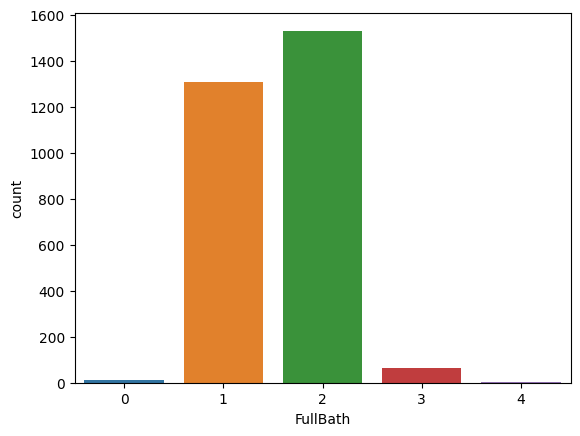

   HalfBath      Ratio
0      1834  62.829736
1      1060  36.313806
2        25   0.856458
###########################################################


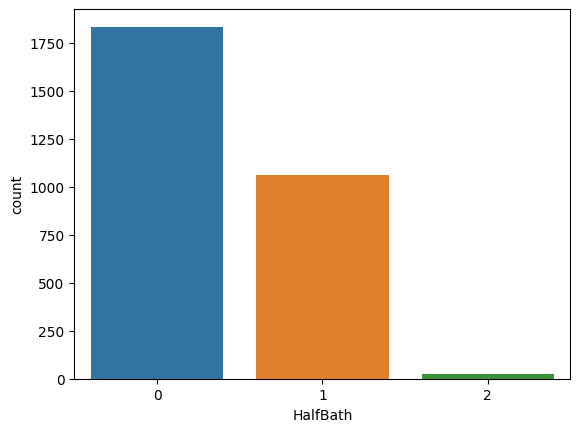

   BedroomAbvGr      Ratio
3          1596  54.676259
2           742  25.419664
4           400  13.703323
1           103   3.528606
5            48   1.644399
6            21   0.719424
0             8   0.274066
8             1   0.034258
###########################################################


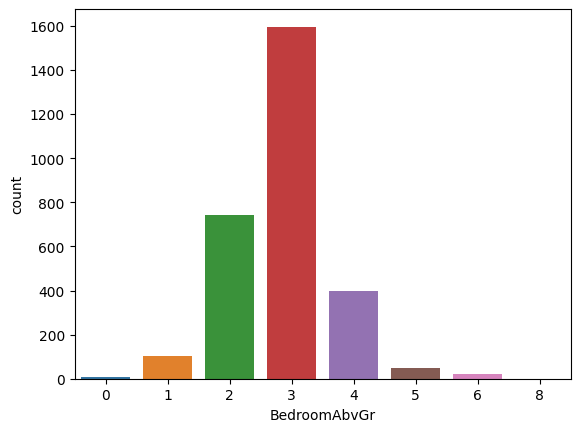

   KitchenAbvGr      Ratio
1          2785  95.409387
2           129   4.419322
0             3   0.102775
3             2   0.068517
###########################################################


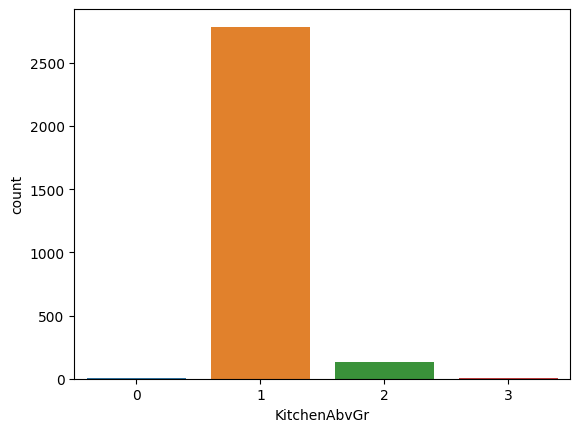

   Fireplaces      Ratio
0        1420  48.646797
1        1268  43.439534
2         219   7.502569
3          11   0.376841
4           1   0.034258
###########################################################


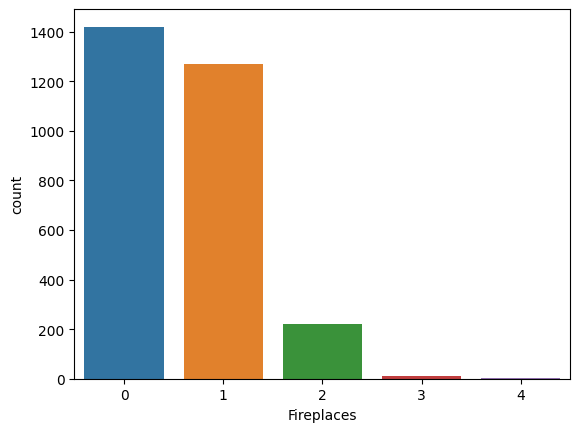

     GarageCars      Ratio
2.0        1594  54.607742
1.0         776  26.584447
3.0         374  12.812607
0.0         157   5.378554
4.0          16   0.548133
5.0           1   0.034258
###########################################################


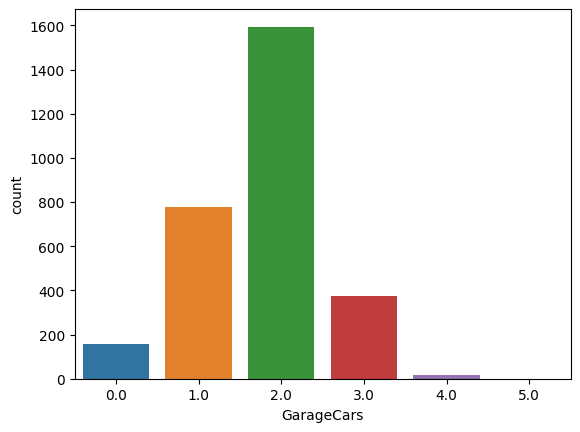

      YrSold      Ratio
2007     692  23.706749
2009     647  22.165125
2008     622  21.308667
2006     619  21.205892
2010     339  11.613566
###########################################################


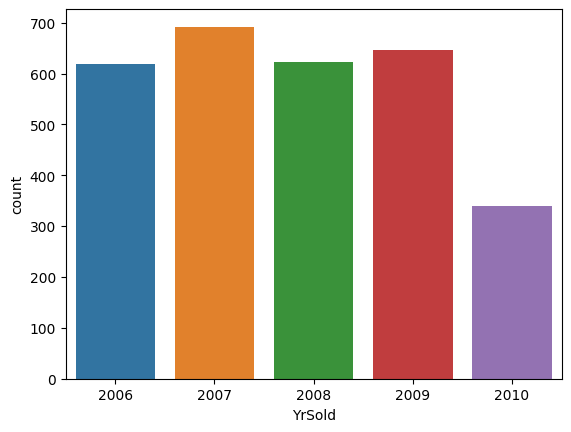

In [20]:
def cat_summary(dataframe, col_name, plot=False):
    if dataframe[col_name].dtypes == "bool":\
        dataframe[col_name] =dataframe[col_name].astype(int)
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100*dataframe[col_name].value_counts()/ len(dataframe)}))
    print("###########################################################")
    if plot:
        sns.countplot(x=dataframe[col_name],data=dataframe)
        plt.show(block=True)
    else:
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100*dataframe[col_name].value_counts()/ len(dataframe)}))
        print("###########################################################")


for col in cat_cols:
    cat_summary(df, col, plot=True)

In [21]:
#Adım 5: Kategorik değişkenler ile hedef değişken incelemesini yapınız.
def target_summary_cat(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")
        

target_summary_cat(df, "SalePrice", cat_cols)

MSZoning : 5
         COUNT    TARGET_MEAN
C (all)     25   74528.000000
FV         139  214014.061538
RH          26  131558.375000
RL        2265  191004.994787
RM         460  126316.830275


Street : 2
      COUNT    TARGET_MEAN
Grvl     12  130190.500000
Pave   2907  181130.538514


Alley : 2
      COUNT    TARGET_MEAN
Grvl    120  122219.080000
Pave     78  168000.585366


LotShape : 4
     COUNT    TARGET_MEAN
IR1    968  206101.665289
IR2     76  239833.365854
IR3     16  216036.500000
Reg   1859  164754.818378


LandContour : 4
     COUNT    TARGET_MEAN
Bnk    117  143104.079365
HLS    120  231533.940000
Low     60  203661.111111
Lvl   2622  180183.746758


Utilities : 2
        COUNT   TARGET_MEAN
AllPub   2916  180950.95682
NoSeWa      1  137500.00000


LotConfig : 5
         COUNT    TARGET_MEAN
Corner     511  181623.425856
CulDSac    176  223854.617021
FR2         85  177934.574468
FR3         14  208475.000000
Inside    2133  176938.047529


LandSlope : 3
     COUNT    T

In [22]:
#Adım 6: Aykırı gözlem var mı inceleyiniz.

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.10)
    quartile3 = dataframe[variable].quantile(0.90)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
for col in num_cols:
    print(col, check_outlier(df, col))


MSSubClass False
LotFrontage True
LotArea True
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea True
BsmtFinSF1 True
BsmtFinSF2 True
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea True
TotRmsAbvGrd True
GarageYrBlt True
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch True
PoolArea True
MiscVal True
MoSold False
SalePrice True


False
0        60
1        20
2        60
3        70
4        60
       ... 
2914    160
2915    160
2916     20
2917     85
2918     60
Name: MSSubClass, Length: 2919, dtype: int64
###########################################################
True


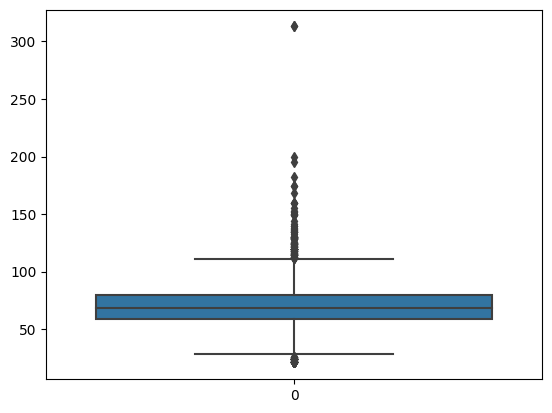

0        65.0
1        80.0
2        68.0
3        60.0
4        84.0
        ...  
2914     21.0
2915     21.0
2916    160.0
2917     62.0
2918     74.0
Name: LotFrontage, Length: 2919, dtype: float64
###########################################################
True


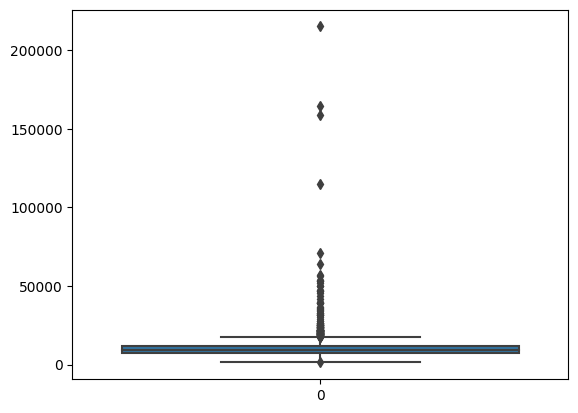

0        8450
1        9600
2       11250
3        9550
4       14260
        ...  
2914     1936
2915     1894
2916    20000
2917    10441
2918     9627
Name: LotArea, Length: 2919, dtype: int64
###########################################################
False
0       7
1       6
2       7
3       7
4       8
       ..
2914    4
2915    4
2916    5
2917    5
2918    7
Name: OverallQual, Length: 2919, dtype: int64
###########################################################
False
0       2003
1       1976
2       2001
3       1915
4       2000
        ... 
2914    1970
2915    1970
2916    1960
2917    1992
2918    1993
Name: YearBuilt, Length: 2919, dtype: int64
###########################################################
False
0       2003
1       1976
2       2002
3       1970
4       2000
        ... 
2914    1970
2915    1970
2916    1996
2917    1992
2918    1994
Name: YearRemodAdd, Length: 2919, dtype: int64
###########################################################
True


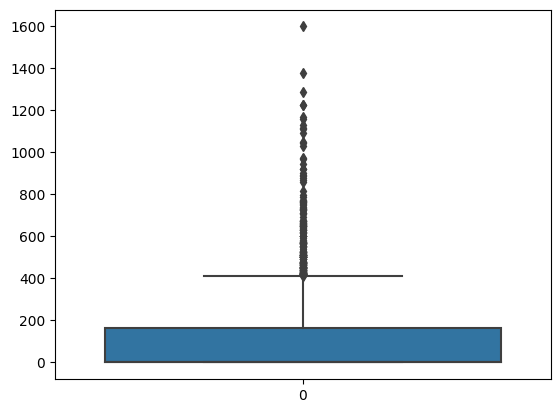

0       196.0
1         0.0
2       162.0
3         0.0
4       350.0
        ...  
2914      0.0
2915      0.0
2916      0.0
2917      0.0
2918     94.0
Name: MasVnrArea, Length: 2919, dtype: float64
###########################################################
True


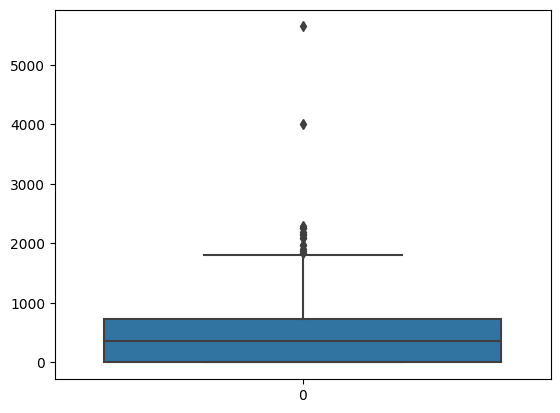

0        706.0
1        978.0
2        486.0
3        216.0
4        655.0
         ...  
2914       0.0
2915     252.0
2916    1224.0
2917     337.0
2918     758.0
Name: BsmtFinSF1, Length: 2919, dtype: float64
###########################################################
True


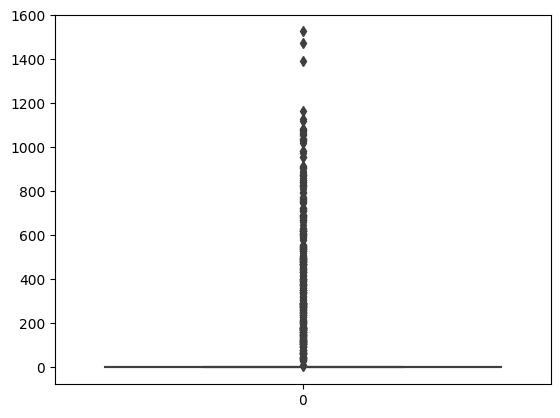

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2914    0.0
2915    0.0
2916    0.0
2917    0.0
2918    0.0
Name: BsmtFinSF2, Length: 2919, dtype: float64
###########################################################
False
0       150.0
1       284.0
2       434.0
3       540.0
4       490.0
        ...  
2914    546.0
2915    294.0
2916      0.0
2917    575.0
2918    238.0
Name: BsmtUnfSF, Length: 2919, dtype: float64
###########################################################
True


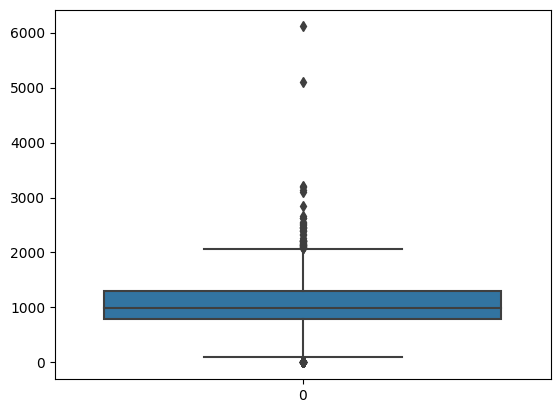

0        856.0
1       1262.0
2        920.0
3        756.0
4       1145.0
         ...  
2914     546.0
2915     546.0
2916    1224.0
2917     912.0
2918     996.0
Name: TotalBsmtSF, Length: 2919, dtype: float64
###########################################################
True


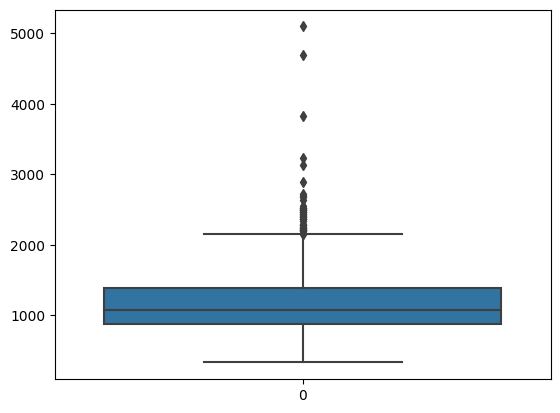

0        856
1       1262
2        920
3        961
4       1145
        ... 
2914     546
2915     546
2916    1224
2917     970
2918     996
Name: 1stFlrSF, Length: 2919, dtype: int64
###########################################################
False
0        854
1          0
2        866
3        756
4       1053
        ... 
2914     546
2915     546
2916       0
2917       0
2918    1004
Name: 2ndFlrSF, Length: 2919, dtype: int64
###########################################################
True


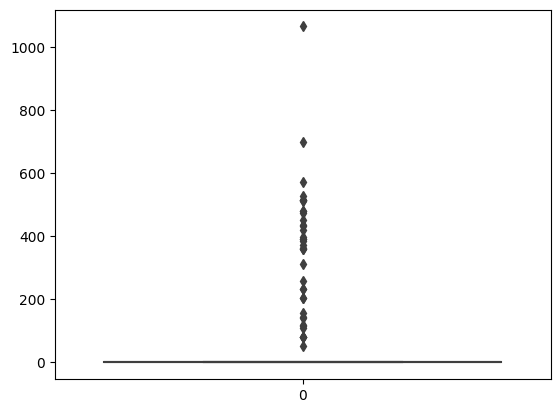

0       0
1       0
2       0
3       0
4       0
       ..
2914    0
2915    0
2916    0
2917    0
2918    0
Name: LowQualFinSF, Length: 2919, dtype: int64
###########################################################
True


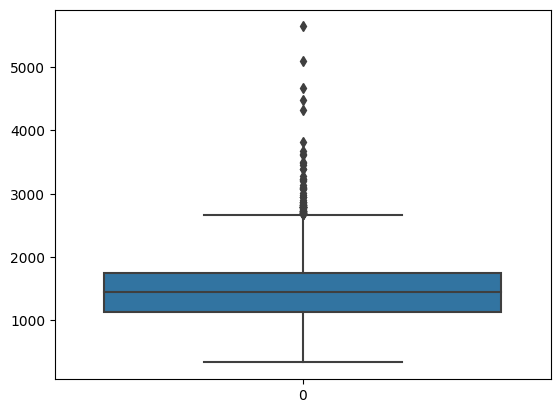

0       1710
1       1262
2       1786
3       1717
4       2198
        ... 
2914    1092
2915    1092
2916    1224
2917     970
2918    2000
Name: GrLivArea, Length: 2919, dtype: int64
###########################################################
True


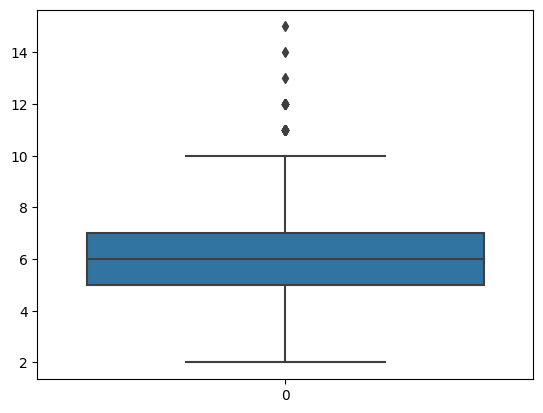

0       8
1       6
2       6
3       7
4       9
       ..
2914    5
2915    6
2916    7
2917    6
2918    9
Name: TotRmsAbvGrd, Length: 2919, dtype: int64
###########################################################
True


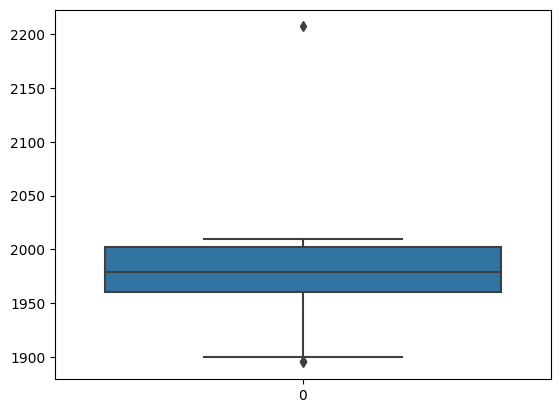

0       2003.0
1       1976.0
2       2001.0
3       1998.0
4       2000.0
         ...  
2914       NaN
2915    1970.0
2916    1960.0
2917       NaN
2918    1993.0
Name: GarageYrBlt, Length: 2919, dtype: float64
###########################################################
False
0       548.0
1       460.0
2       608.0
3       642.0
4       836.0
        ...  
2914      0.0
2915    286.0
2916    576.0
2917      0.0
2918    650.0
Name: GarageArea, Length: 2919, dtype: float64
###########################################################
True


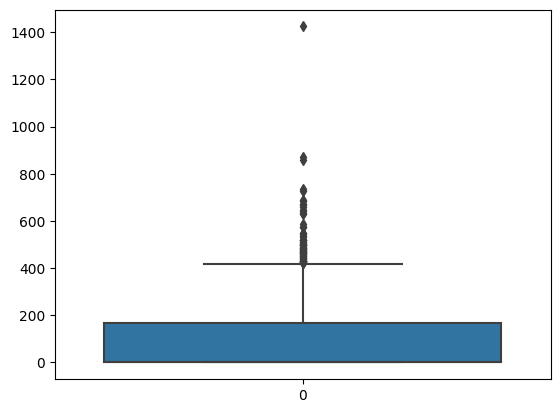

0         0
1       298
2         0
3         0
4       192
       ... 
2914      0
2915      0
2916    474
2917     80
2918    190
Name: WoodDeckSF, Length: 2919, dtype: int64
###########################################################
True


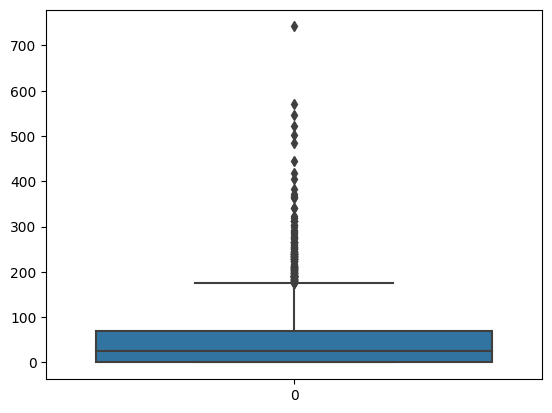

0       61
1        0
2       42
3       35
4       84
        ..
2914     0
2915    24
2916     0
2917    32
2918    48
Name: OpenPorchSF, Length: 2919, dtype: int64
###########################################################
True


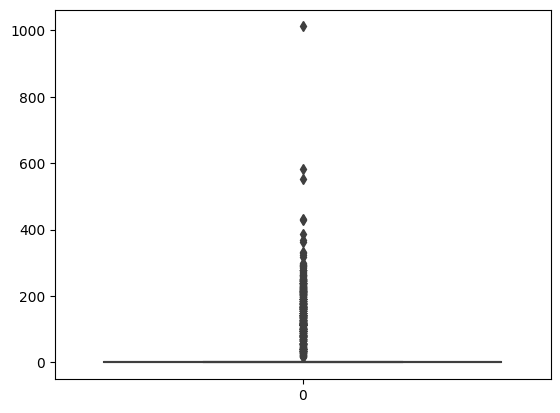

0         0
1         0
2         0
3       272
4         0
       ... 
2914      0
2915      0
2916      0
2917      0
2918      0
Name: EnclosedPorch, Length: 2919, dtype: int64
###########################################################
True


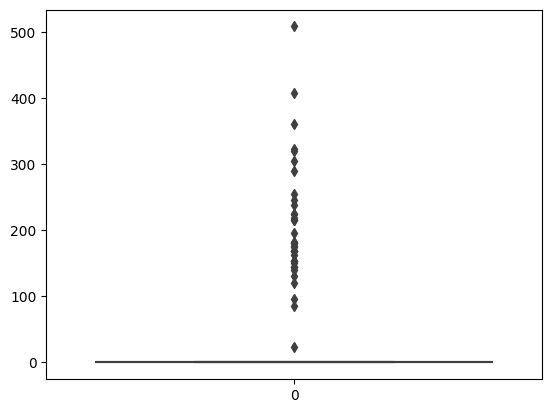

0       0
1       0
2       0
3       0
4       0
       ..
2914    0
2915    0
2916    0
2917    0
2918    0
Name: 3SsnPorch, Length: 2919, dtype: int64
###########################################################
True


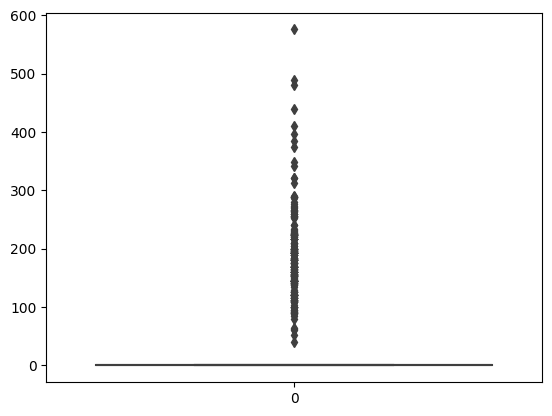

0       0
1       0
2       0
3       0
4       0
       ..
2914    0
2915    0
2916    0
2917    0
2918    0
Name: ScreenPorch, Length: 2919, dtype: int64
###########################################################
True


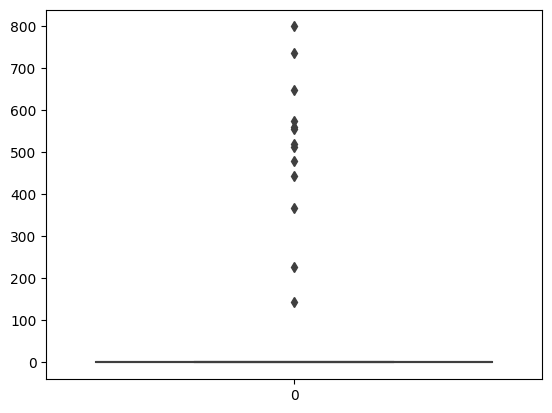

0       0
1       0
2       0
3       0
4       0
       ..
2914    0
2915    0
2916    0
2917    0
2918    0
Name: PoolArea, Length: 2919, dtype: int64
###########################################################
True


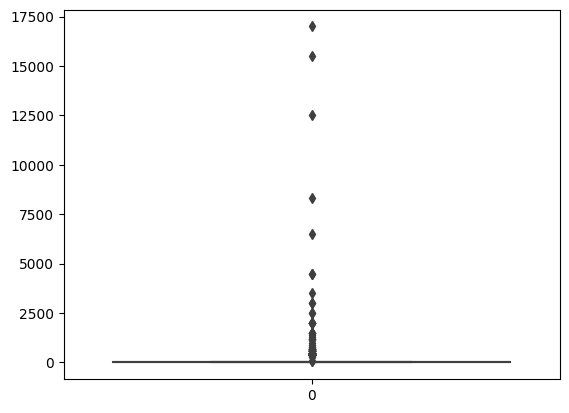

0         0
1         0
2         0
3         0
4         0
       ... 
2914      0
2915      0
2916      0
2917    700
2918      0
Name: MiscVal, Length: 2919, dtype: int64
###########################################################
False
0        2
1        5
2        9
3        2
4       12
        ..
2914     6
2915     4
2916     9
2917     7
2918    11
Name: MoSold, Length: 2919, dtype: int64
###########################################################
True


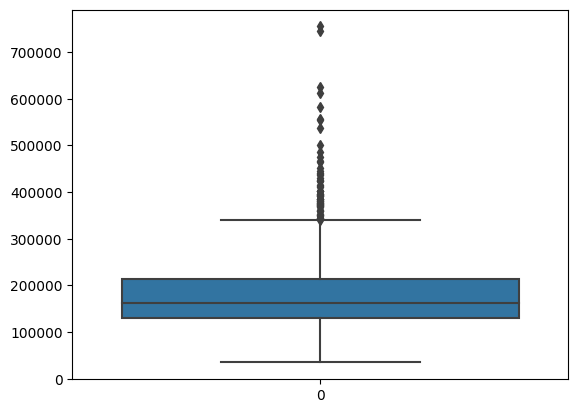

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
2914         NaN
2915         NaN
2916         NaN
2917         NaN
2918         NaN
Name: SalePrice, Length: 2919, dtype: float64
###########################################################


In [23]:
def check_outlier_graph(dataframe, col_name, plot= False):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        print(True)
        if plot:
            sns.boxplot(dataframe[col_name])
            plt.show(block= True)
            print(dataframe[col_name])
            print("###########################################################")
    else:
        print(False)
        print(dataframe[col_name])
        print("###########################################################")

for col in num_cols:
    check_outlier_graph(df, col, plot=True)



              n_miss  ratio
PoolQC          2909  99.66
MiscFeature     2814  96.40
Alley           2721  93.22
Fence           2348  80.44
SalePrice       1459  49.98
FireplaceQu     1420  48.65
LotFrontage      486  16.65
GarageCond       159   5.45
GarageYrBlt      159   5.45
GarageFinish     159   5.45
GarageQual       159   5.45
GarageType       157   5.38
BsmtExposure      82   2.81
BsmtCond          82   2.81
BsmtQual          81   2.77
BsmtFinType2      80   2.74
BsmtFinType1      79   2.71
MasVnrType        24   0.82
MasVnrArea        23   0.79
MSZoning           4   0.14
Functional         2   0.07
BsmtHalfBath       2   0.07
BsmtFullBath       2   0.07
Utilities          2   0.07
KitchenQual        1   0.03
TotalBsmtSF        1   0.03
BsmtUnfSF          1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
BsmtFinSF2         1   0.03
BsmtFinSF1         1   0.03
Exterior2nd        1   0.03
Exterior1st        1   0.03
SaleType           1   0.03
Electrical         1

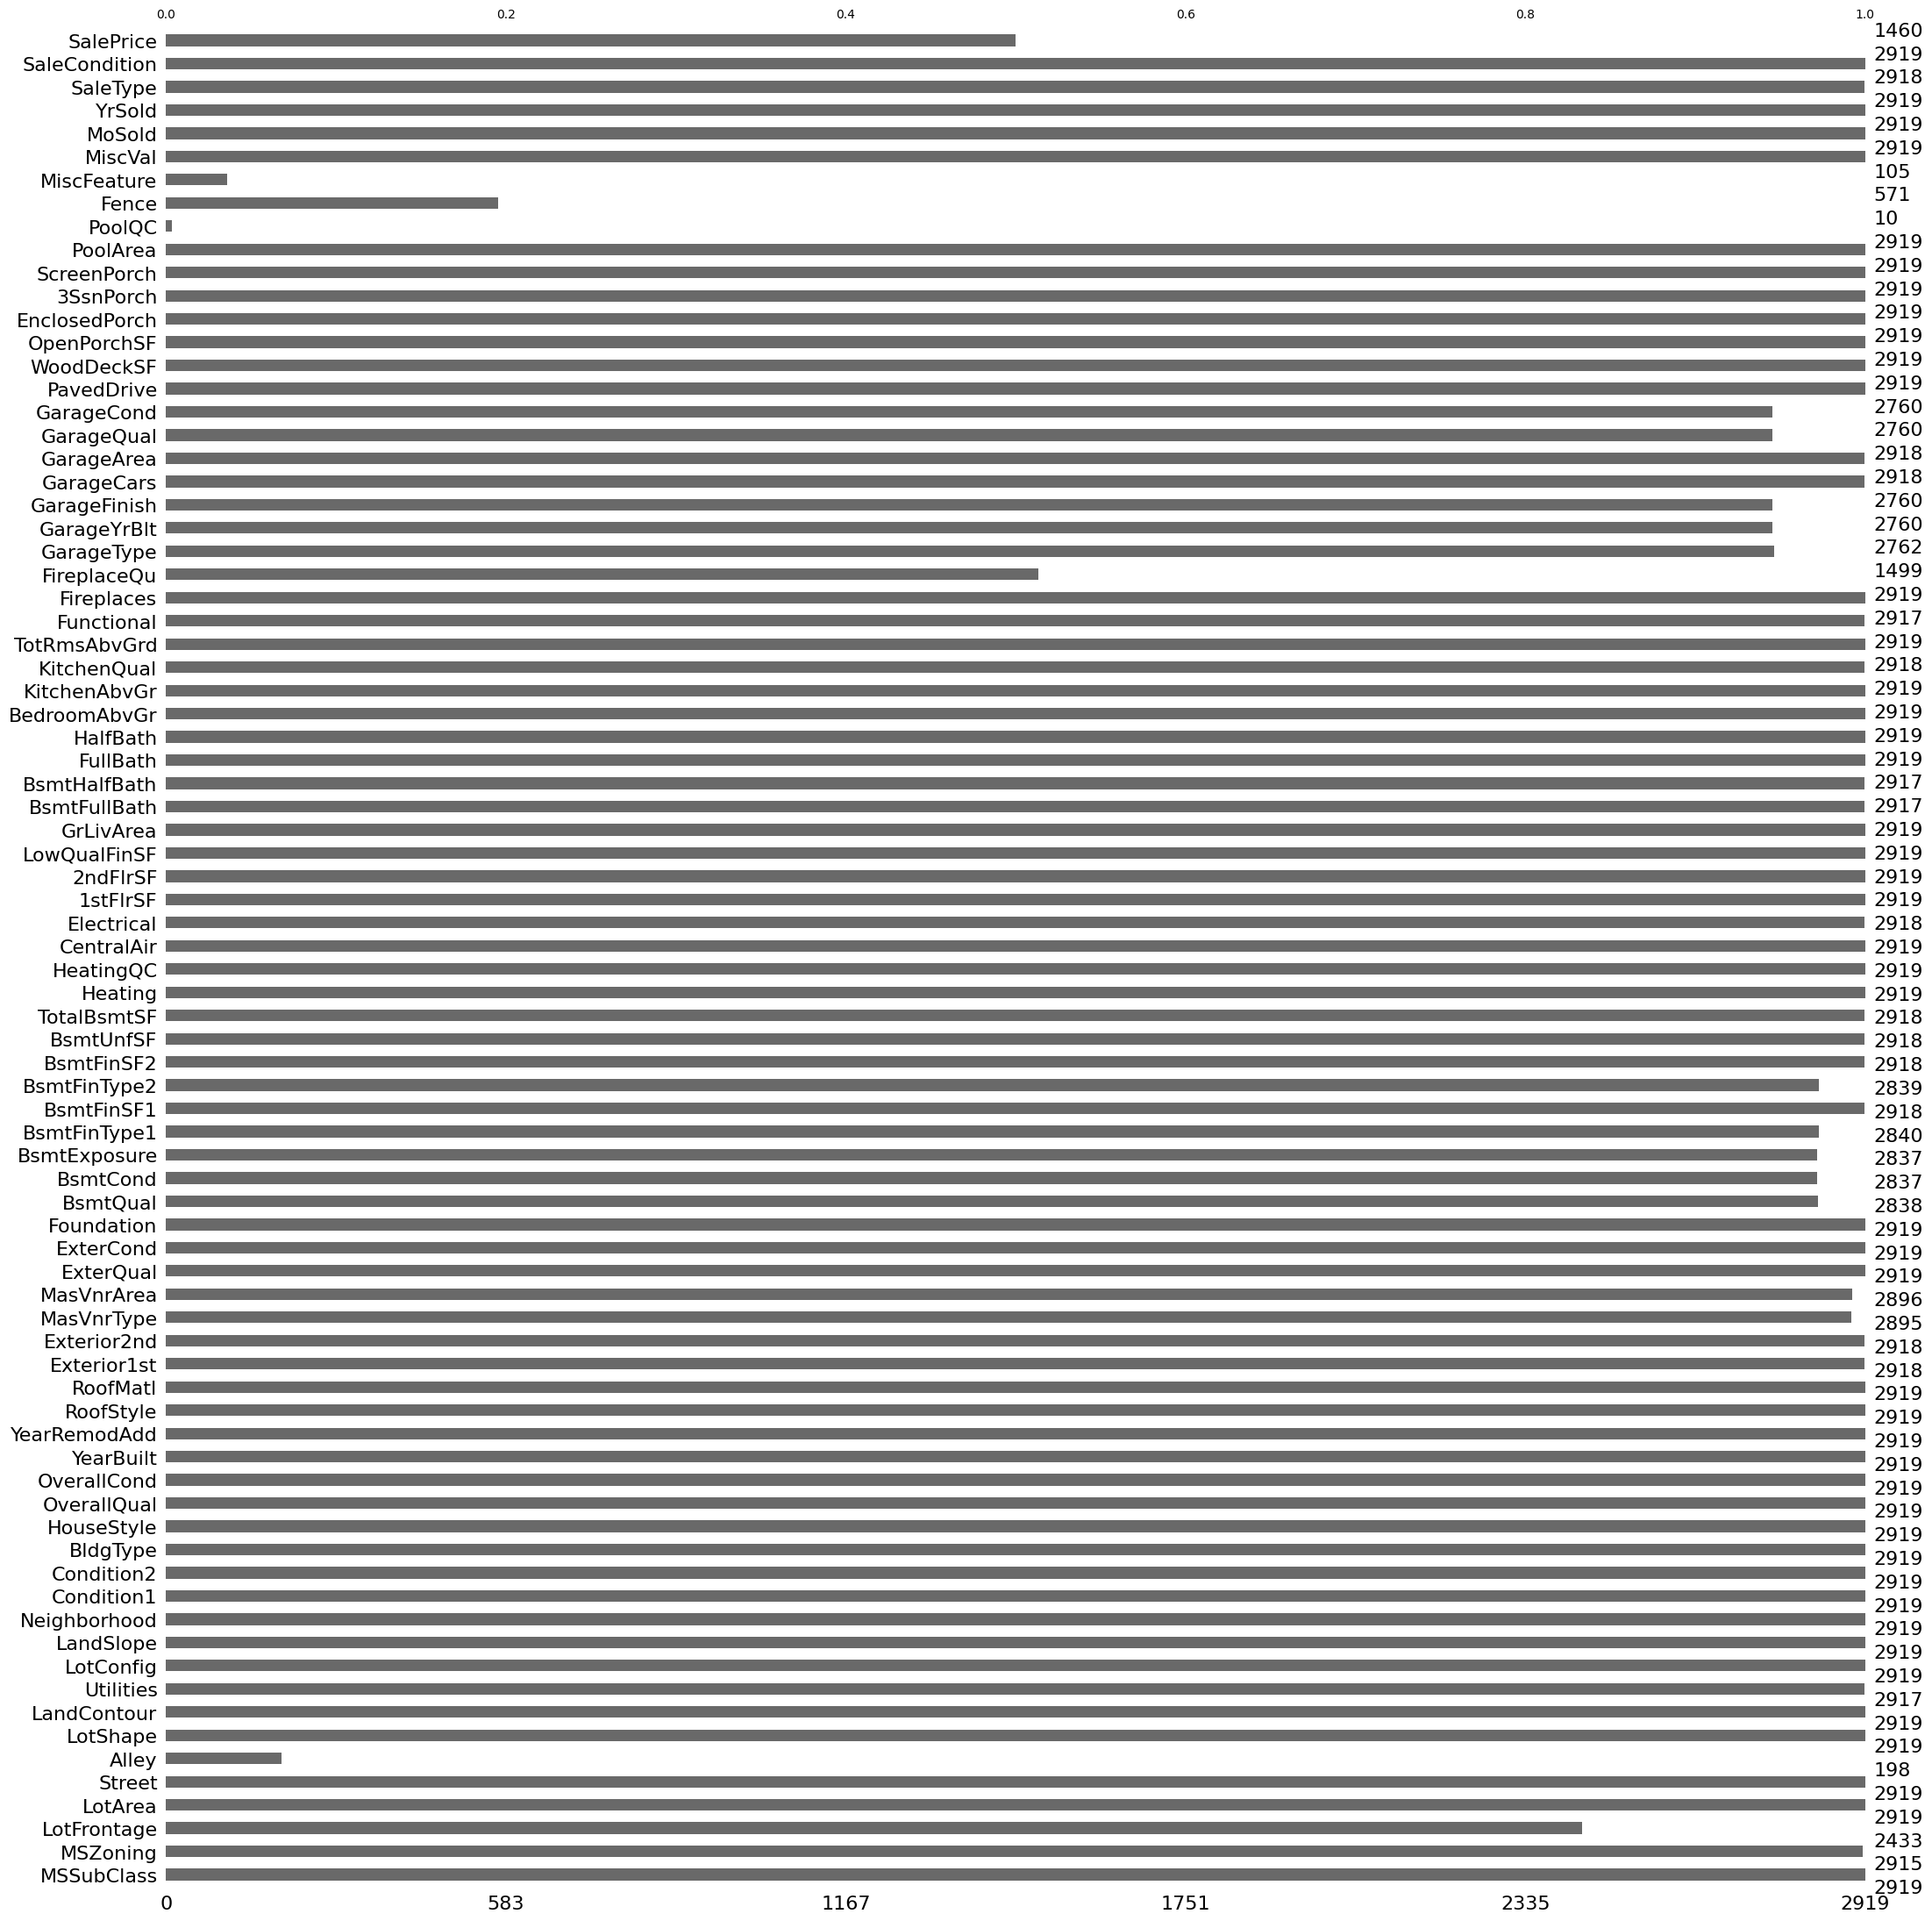

['MSZoning',
 'LotFrontage',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SalePrice']

In [24]:
#Adım 7: Eksik gözlem var mı inceleyiniz.

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    msno.bar(df)
    plt.show()
    if na_name:
        return na_columns


missing_values_table(df, True)


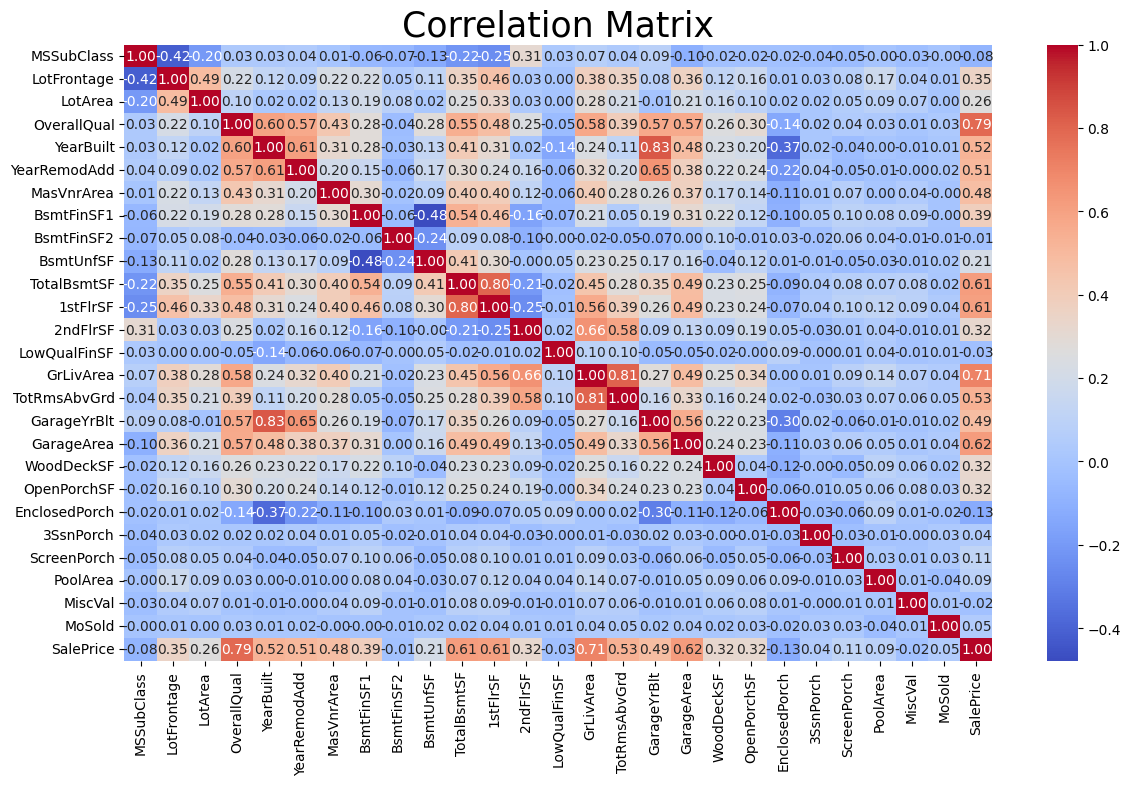

In [25]:
f, ax = plt.subplots(figsize=[14, 8])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f")
ax.set_title("Correlation Matrix", fontsize=25)
plt.show()

In [26]:
#Görev 2: Feature Engineering
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [27]:
#Adım 1: Eksik ve aykırı gözlemler için gerekli işlemleri yapınız.
for col in num_cols:
    replace_with_thresholds(df, col)

df.describe()

#df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2919.000000,2919.000000,2919.000000,2919.0,2919.0,2919.0,2919.0,2919.000000,2919.000000,1460.000000
mean,57.137718,69.166050,9818.098082,6.089072,5.564577,1971.312778,1984.264474,100.025035,439.925805,29.308773,...,93.174546,46.828708,22.354231,0.0,0.0,0.0,0.0,6.213087,2007.792737,180450.736301
std,42.517628,22.345476,4351.591398,1.409947,1.113131,30.291442,20.894344,168.034986,444.134292,85.778123,...,123.169563,63.694364,58.955344,0.0,0.0,0.0,0.0,2.714762,1.314964,76826.747214
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,4.000000,2007.000000,129975.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,0.000000,26.000000,0.000000,0.0,0.0,0.0,0.0,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,168.000000,70.000000,0.000000,0.0,0.0,0.0,0.0,8.000000,2009.000000,214000.000000
max,190.000000,173.000000,28367.900000,10.000000,9.000000,2010.000000,2010.000000,813.750000,2642.250000,314.000000,...,642.500000,328.000000,280.000000,0.0,0.0,0.0,0.0,12.000000,2010.000000,535287.500000


In [28]:
df.isnull().sum()

MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
                 ... 
MoSold              0
YrSold              0
SaleType            1
SaleCondition       0
SalePrice        1459
Length: 80, dtype: int64

In [29]:
df["PoolQC"].fillna("NPQC", inplace=True)
df["MiscFeature"].fillna("NPMF", inplace=True)
df["Alley"].fillna("NPA", inplace=True)
df["Fence"].fillna("NPF", inplace=True)
df["FireplaceQu"].fillna("NPFP", inplace=True)

df=df.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" and x.name != "SalePrice" else x, axis=0)
df=df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)
df = pd.DataFrame(df, columns=df.columns)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450.0,Pave,NPA,Reg,Lvl,AllPub,Inside,...,0,NPQC,NPF,NPMF,0,2.0,2008,WD,Normal,208500.0
1,20,RL,80.0,9600.0,Pave,NPA,Reg,Lvl,AllPub,FR2,...,0,NPQC,NPF,NPMF,0,5.0,2007,WD,Normal,181500.0
2,60,RL,68.0,11250.0,Pave,NPA,IR1,Lvl,AllPub,Inside,...,0,NPQC,NPF,NPMF,0,9.0,2008,WD,Normal,223500.0
3,70,RL,60.0,9550.0,Pave,NPA,IR1,Lvl,AllPub,Corner,...,0,NPQC,NPF,NPMF,0,2.0,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260.0,Pave,NPA,IR1,Lvl,AllPub,FR2,...,0,NPQC,NPF,NPMF,0,12.0,2008,WD,Normal,250000.0


In [30]:
df.isnull().sum()

MSSubClass          0
MSZoning            0
LotFrontage         0
LotArea             0
Street              0
                 ... 
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
SalePrice        1459
Length: 80, dtype: int64

In [31]:
#Adım 2: Rare Encoder uygulayınız.
cat_cols

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'OverallCond',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageCars',
 'YrSold']

In [32]:
#kategorik değişkenlerin kendi kendi içindeki dağılımları
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df, col)

         MSZoning      Ratio
RL           2269  77.732100
RM            460  15.758822
FV            139   4.761905
RH             26   0.890716
C (all)        25   0.856458
##########################################
      Street    Ratio
Pave    2907  99.5889
Grvl      12   0.4111
##########################################
      Alley      Ratio
NPA    2721  93.216855
Grvl    120   4.110997
Pave     78   2.672148
##########################################
     LotShape      Ratio
Reg      1859  63.686194
IR1       968  33.162042
IR2        76   2.603631
IR3        16   0.548133
##########################################
     LandContour      Ratio
Lvl         2622  89.825283
HLS          120   4.110997
Bnk          117   4.008222
Low           60   2.055498
##########################################
        Utilities      Ratio
AllPub       2918  99.965742
NoSeWa          1   0.034258
##########################################
         LotConfig      Ratio
Inside        2133  73.07297

In [33]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "SalePrice", cat_cols)

MSZoning : 5
         COUNT     RATIO    TARGET_MEAN
C (all)     25  0.008565   74528.000000
FV         139  0.047619  214014.061538
RH          26  0.008907  131558.375000
RL        2269  0.777321  190408.234579
RM         460  0.157588  126316.830275


Street : 2
      COUNT     RATIO    TARGET_MEAN
Grvl     12  0.004111  130190.500000
Pave   2907  0.995889  180658.137552


Alley : 3
      COUNT     RATIO    TARGET_MEAN
Grvl    120  0.041110  122219.080000
NPA    2721  0.932169  182950.399562
Pave     78  0.026721  168000.585366


LotShape : 4
     COUNT     RATIO    TARGET_MEAN
IR1    968  0.331620  204827.284091
IR2     76  0.026036  239767.207317
IR3     16  0.005481  216036.500000
Reg   1859  0.636862  164681.998919


LandContour : 4
     COUNT     RATIO    TARGET_MEAN
Bnk    117  0.040082  143104.079365
HLS    120  0.041110  231479.690000
Low     60  0.020555  203661.111111
Lvl   2622  0.898253  179661.886728


Utilities : 2
        COUNT     RATIO    TARGET_MEAN
AllPub   2918  

          COUNT     RATIO    TARGET_MEAN
0.000000    157  0.053786  103317.283951
1.000000    776  0.265844  128116.688347
1.766621      1  0.000343            NaN
2.000000   1594  0.546077  183851.663835
3.000000    374  0.128126  305841.254144
4.000000     16  0.005481  192655.800000
5.000000      1  0.000343            NaN


YrSold : 5
      COUNT     RATIO    TARGET_MEAN
2006    619  0.212059  182195.936306
2007    692  0.237067  184757.908815
2008    622  0.213087  177360.838816
2009    647  0.221651  179232.819527
2010    339  0.116136  176941.777143




In [34]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

#rare oranı 0.01 bu oranın altında kalan sınıfları birleştirir
new_df = rare_encoder(df, 0.01)

In [35]:
new_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450.0,Pave,NPA,Reg,Lvl,AllPub,Inside,...,0,NPQC,NPF,NPMF,0,2.0,2008,WD,Normal,208500.0
1,20,RL,80.0,9600.0,Pave,NPA,Reg,Lvl,AllPub,FR2,...,0,NPQC,NPF,NPMF,0,5.0,2007,WD,Normal,181500.0
2,60,RL,68.0,11250.0,Pave,NPA,IR1,Lvl,AllPub,Inside,...,0,NPQC,NPF,NPMF,0,9.0,2008,WD,Normal,223500.0
3,70,RL,60.0,9550.0,Pave,NPA,IR1,Lvl,AllPub,Corner,...,0,NPQC,NPF,NPMF,0,2.0,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260.0,Pave,NPA,IR1,Lvl,AllPub,FR2,...,0,NPQC,NPF,NPMF,0,12.0,2008,WD,Normal,250000.0


In [36]:
#Adım 3: Yeni değişkenler oluşturunuz.
new_df["NEW_1st*GrLiv"] = new_df["1stFlrSF"] * new_df["GrLivArea"]

new_df["NEW_Garage*GrLiv"] = (new_df["GarageArea"] * new_df["GrLivArea"])

new_df["TotalQual"] = new_df[["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtCond", "BsmtFinType1",
                      "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageQual", "GarageCond", "Fence"]].sum(axis = 1) # 42


# Total Floor
new_df["NEW_TotalFlrSF"] = new_df["1stFlrSF"] + new_df["2ndFlrSF"] # 32

# Total Finished Basement Area
new_df["NEW_TotalBsmtFin"] = new_df.BsmtFinSF1 + df.BsmtFinSF2 # 56

# Porch Area
new_df["NEW_PorchArea"] = new_df.OpenPorchSF + new_df.EnclosedPorch + new_df.ScreenPorch + new_df["3SsnPorch"] + new_df.WoodDeckSF # 93

# Total House Area
new_df["NEW_TotalHouseArea"] = new_df.NEW_TotalFlrSF + new_df.TotalBsmtSF # 156

new_df["NEW_TotalSqFeet"] = new_df.GrLivArea + new_df.TotalBsmtSF # 35


# Lot Ratio
new_df["NEW_LotRatio"] = new_df.GrLivArea / new_df.LotArea # 64

new_df["NEW_RatioArea"] = new_df.NEW_TotalHouseArea / new_df.LotArea # 57

new_df["NEW_GarageLotRatio"] = new_df.GarageArea / new_df.LotArea # 69

# MasVnrArea
new_df["NEW_MasVnrRatio"] = new_df.MasVnrArea / new_df.NEW_TotalHouseArea # 36

# Dif Area
new_df["NEW_DifArea"] = (new_df.LotArea - new_df["1stFlrSF"] - new_df.GarageArea - new_df.NEW_PorchArea - new_df.WoodDeckSF) # 73


new_df["NEW_OverallGrade"] = new_df["OverallQual"] * new_df["OverallCond"] # 61


new_df["NEW_Restoration"] = new_df.YearRemodAdd - new_df.YearBuilt # 31

new_df["NEW_HouseAge"] = new_df.YrSold - new_df.YearBuilt # 73

new_df["NEW_RestorationAge"] = new_df.YrSold - new_df.YearRemodAdd # 40

new_df["NEW_GarageAge"] = new_df.GarageYrBlt - new_df.YearBuilt # 17

new_df["NEW_GarageRestorationAge"] = np.abs(new_df.GarageYrBlt - new_df.YearRemodAdd) # 30

new_df["NEW_GarageSold"] = new_df.YrSold - new_df.GarageYrBlt # 48


In [1]:
drop_list = ["Street", "Alley", "LandContour", "Utilities", "LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood"]
new_df.drop(drop_list, axis = 1, inplace=True)

NameError: name 'new_df' is not defined

In [ ]:
#Adım 4: Encoding işlemlerini gerçekleştiriniz.
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler


def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


binary_cols = [col for col in new_df.columns if new_df[col].dtype not in [int, float]
               and new_df[col].nunique() == 2]

label_cols = [col for col in new_df.columns if new_df[col].dtype not in [int, float]
               and new_df[col].nunique() > 2]

for col in binary_cols:
    label_encoder(new_df, col)

for col in label_cols:
    label_encoder(new_df, col)
    
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in new_df.columns if 10 >= new_df[col].nunique() > 2]

one_hot_encoder(new_df, ohe_cols)

new_df.head()


In [ ]:
pd.set_option('display.max_columns', None)
new_df.head()

In [ ]:
cat_cols, num_cols,cat_but_car,num_but_cat= grab_col_names(df)

In [ ]:
num_cols

In [ ]:
#mms = MinMaxScaler()
#new_df[num_cols] = mms.fit_transform(new_df[num_cols])
#new_df.head()

In [ ]:
#Görev 3: Model Kurma
#Adım 1: Train ve Test verisini ayırınız. (SalePrice değişkeni boş olan değerler test verisidir.)

In [ ]:
test_dataframe = new_df[new_df['SalePrice'].isnull()]
test_dataframe.head()

In [ ]:
train_dataframe = new_df[new_df['SalePrice'].notnull()]
train_dataframe.head()

In [ ]:
train_dataframe.isnull().sum().sum()

In [ ]:
#Adım 2: Train verisi ile model kurup, model başarısını değerlendiriniz.
#Bonus: Hedef değişkene log dönüşümü yaparak model kurunuz ve rmse sonuçlarını gözlemleyiniz. 
#Not: Log'un tersini (inverse) almayı unutmayınız

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


In [ ]:
y = train_dataframe["SalePrice"]
X = train_dataframe.drop(["SalePrice"], axis=1)

train_dataframe["SalePrice"] = train_dataframe["SalePrice"].astype('int64')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [ ]:
models = [('LR', LinearRegression()),
          #("Ridge", Ridge()),
          #("Lasso", Lasso()),
          #("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          #('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]
          # ("CatBoost", CatBoostRegressor(verbose=False))]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")


In [ ]:
#Adım 3: Hiperparemetre optimizasyonu gerçekleştiriniz.
lgbm_model = LGBMRegressor(random_state=46)

rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model, X, y, cv=5, scoring="neg_mean_squared_error")))


lgbm_params = {"learning_rate": [0.01, 0.02, 0.05, 0.1],
               "n_estimators": [200, 300, 350, 400, 500, 1500],
               "colsample_bytree": [0.5, 0.7, 0.9, 0.8, 1]}

lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=3,
                            n_jobs=-1,
                            verbose=True).fit(X, y)



final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

lgbm_gs_best.best_params_

In [ ]:
cv_results = cross_validate(final_model, X, y, cv=5, scoring="neg_mean_squared_error")
cv_results

In [ ]:
cv_results['fit_time'].mean()

In [ ]:
cv_results['score_time'].mean()

In [ ]:
cv_results['test_score'].mean()

In [ ]:
#Adım 4: Değişken önem düzeyini inceleyeniz.
#Bonus: Test verisinde boş olan salePrice değişkenlerini tahminleyiniz ve Kaggle sayfasına submit etmeye uygun halde bir
#dataframe oluşturup sonucunuzu yükleyiniz

In [ ]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(18, 18))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(final_model, X_train)